# San Francisco Affordable Housing Predictive Modeling

---

## Part 4: Clustering Model

---

## Notebook Summary

This notebook preserves our most salient housing features and iterates through first a primarily numeric and second a primarily categorical set of features for the purposes of clustering. A final production model is iterated upon using the best features from both numeric and categorical variables and then some EDA is done on the resultant clusters in our production model. In this notebook, the reader will find:

* Numeric Features Clustering Model Tuning
* Categorical Features Clustering Model Tuning
* Clustering Production Model & EDA
* Notebook Conclusion

---

## Numeric Features Clustering Model Tuning

In this section, we will tune a clustering model using primarily numeric features. We will begin by importing our requisite libraries and reading in our dataset. Then, we will make a couple different copies of the data frame for clustering, one using primarily our numeric data, including things like units, affordable units, square footage of different land uses, etc. and in a subsequent section, another using primarily the geographic data, including things like zoning and supervisorial districts.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

In [2]:
# read in data frame
sf_dev_projs = pd.read_csv('../data/five_yr_pipeline.csv', low_memory = False)

In [3]:
# preview data frame
sf_dev_projs

landuse             nameaddr entitled      beststat  \
0      Resident          836 48TH AV        1  CONSTRUCTION   
1        Vacant        735 BRYANT ST        1  CONSTRUCTION   
2      Resident     2626 GRIFFITH ST        1  CONSTRUCTION   
3      Resident         49 SUSSEX ST        1   BP APPROVED   
4      Resident     1247 BOSWORTH ST        1     BP ISSUED   
...         ...                  ...      ...           ...   
43197  Resident     964 - 966 OAK ST     True      BP FILED   
43198   Unknown         505 26TH AVE    False      PL FILED   
43199   Unknown       2808 FOLSOM ST    False      PL FILED   
43200       CIE       327 CAPITOL AV     True  CONSTRUCTION   
43201  Resident  923 - 939 KANSAS ST    False      BP FILED   

                     bestdate  units    tcocfcdate  tcocfcunits  unitsnet  \
0      09/20/2021 11:44:06 AM    2.0  None applied          0.0       1.0   
1      07/26/2019 12:00:00 AM    0.0  None applied          0.0       0.0   
2      10/20/2021 11:10:35 AM    1.0  None applied          0.0       1.0   
3      12/13/2019 09:43:07 AM    1.0  None applied          0.0       1.0   
4      08/10/2022 12:00:00 AM    1.0  None applied          0.0       1.0   
...                       ...    ...           ...          ...       ...   
43197  02/09/2017 12:00:00 AM    2.0  None applied          0.0       0.0   
43198  02/01/2018 12:00:00 AM    3.0  None applied          0.0       3.0   
43199  03/16/2018 12:00:00 AM    2.0  None applied          0.0       2.0   
43200  03/08/2018 12:00:00 AM    0.0  None applied          0.0       0.0   
43201  07/02/2014 12:00:00 AM    2.0  None applied          0.0       2.0   

       pipelineunits  ...  heightbul                              pda  \
0                1.0  ...       40-X               Richmond Corridors   
1                0.0  ...     270-CS            Eastern Neighborhoods   
2                1.0  ...       40-X  Bayview/Southeast Neighborhoods   
3                1.0  ...       40-X    J Church and Mission Corridor   
4                1.0  ...       40-X                                0   
...              ...  ...        ...                              ...   
43197            1.0  ...    Unknown                 Rest of the City   
43198            1.0  ...    Unknown                 Rest of the City   
43199            1.0  ...    Unknown            Eastern Neighborhoods   
43200            0.0  ...    Unknown                 Rest of the City   
43201            1.0  ...    Unknown            Eastern Neighborhoods   

        longitude   latitude    year  qtr  yearqtr  \
0     -122.508817  37.772600  2022.0   Q4  2022_Q4   
1     -122.400848  37.776946  2022.0   Q4  2022_Q4   
2     -122.388080  37.718621  2022.0   Q4  2022_Q4   
3     -122.433855  37.736508  2022.0   Q4  2022_Q4   
4     -122.441421  37.735635  2022.0   Q4  2022_Q4   
...           ...        ...     ...  ...      ...   
43197         NaN        NaN  2018.0   Q1  2018_Q1   
43198         NaN        NaN  2018.0   Q1  2018_Q1   
43199         NaN        NaN  2018.0   Q1  2018_Q1   
43200         NaN        NaN  2018.0   Q1  2018_Q1   
43201         NaN        NaN  2018.0   Q1  2018_Q1   

                                    latlong  currentpolicedistricts  \
0           POINT (-122.5088171 37.7725997)                     8.0   
1      POINT (-122.400848374 37.7769458793)                     1.0   
2      POINT (-122.388080214 37.7186214874)                     2.0   
3      POINT (-122.433855046 37.7365078557)                     9.0   
4      POINT (-122.441420855 37.7356345978)                     9.0   
...                                     ...                     ...   
43197        (37.7736998606, -122.43522293)                     4.0   
43198       (37.7797312955, -122.485978127)                     8.0   
43199       (37.7521940241, -122.414253165)                     3.0   
43200       (37.7135532116, -122.459302748)                    10.0   
43201       (37.758

In [4]:
# check data types
sf_dev_projs.dtypes

landuse                    object
nameaddr                   object
entitled                   object
beststat                   object
bestdate                   object
units                     float64
tcocfcdate                 object
tcocfcunits               float64
unitsnet                  float64
pipelineunits             float64
affordablenet             float64
afftarget                  object
totalgsf                  float64
netgsf                    float64
cieexist                  float64
cie                       float64
cienet                    float64
medexist                  float64
med                       float64
mednet                    float64
mipsexist                 float64
mips                      float64
mipsnet                   float64
pdrexist                  float64
pdr                       float64
pdrnet                    float64
retexist                  float64
ret                       float64
retnet                    float64
visitexist    

Before making multiple copies of our original data frame for clustering, we shall first preprocess some of the data by dropping duplicate addresses as well as columns which we will not use in any clustering model. We will then mask the data frame for only the two land uses with which we are most concerned in our analysis, residential and mixed residential. Then, we shal make two separate copies of the cleaned up and preprocessed data frame to iterate on a few clustering models.

In [5]:
# drop duplicate addresses
sf_dev_projs.drop_duplicates(subset = 'nameaddr', inplace = True)

In [6]:
# drop columns not to be used in any clustering model
sf_dev_projs.drop(columns = ['tcocfcdate', 
                             'year', 
                             'qtr', 
                             'yearqtr', 
                             'nameaddr', 
                             'bestdate',
                             'latlong'
                            ], 
                  inplace = True)

In [7]:
# check null counts
sf_dev_projs.isnull().sum().sort_values(ascending = False)

latitude                  215
longitude                 215
pd                          8
landuse                     0
hotelroomnet                0
ret                         0
retnet                      0
visitexist                  0
visit                       0
visitnet                    0
hotelroomexist              0
hotelroomprop               0
adu                         0
legalization                0
entitled                    0
sd22                        0
nhood41                     0
zoning                      0
heightbul                   0
pda                         0
currentpolicedistricts      0
retexist                    0
pdrnet                      0
pdr                         0
netgsf                      0
beststat                    0
units                       0
tcocfcunits                 0
unitsnet                    0
pipelineunits               0
affordablenet               0
afftarget                   0
totalgsf                    0
cieexist  

In [8]:
# drop nulls
sf_dev_projs.dropna(inplace = True)

In [9]:
# mask for just rows with residential land uses
resident = sf_dev_projs[sf_dev_projs['landuse'] == 'Resident']

In [10]:
# mask for ust rows with mixed residential land uses
mixedres = sf_dev_projs[sf_dev_projs['landuse'] == 'Mixres']

In [11]:
# concatenate both residential and mixed residential data frames
sf_dev_projs = pd.concat([resident, mixedres])

In [12]:
# preview new data frame with just residential and mixed residential land uses
sf_dev_projs

landuse entitled      beststat  units  tcocfcunits  unitsnet  \
0      Resident        1  CONSTRUCTION    2.0          0.0       1.0   
2      Resident        1  CONSTRUCTION    1.0          0.0       1.0   
3      Resident        1   BP APPROVED    1.0          0.0       1.0   
4      Resident        1     BP ISSUED    1.0          0.0       1.0   
5      Resident        1  CONSTRUCTION    3.0          0.0       1.0   
...         ...      ...           ...    ...          ...       ...   
39798    Mixres     True  CONSTRUCTION   32.0          0.0      32.0   
39960    Mixres     True  CONSTRUCTION    2.0          0.0       2.0   
40981    Mixres     True   BP APPROVED    3.0          0.0       1.0   
41190    Mixres     True     BP ISSUED    0.0          0.0       0.0   
41213    Mixres     True      BP FILED    2.0          0.0      -1.0   

       pipelineunits  affordablenet              afftarget  totalgsf  ...  \
0                1.0            0.0  No Affordable Housing       0.0  ...   
2                1.0            0.0  No Affordable Housing       0.0  ...   
3                1.0            0.0  No Affordable Housing       0.0  ...   
4                1.0            0.0  No Affordable Housing       0.0  ...   
5                1.0            0.0  No Affordable Housing       0.0  ...   
...              ...            ...                    ...       ...  ...   
39798            3.0            3.0  No Affordable Housing    1813.0  ...   
39960            3.0            0.0  No Affordable Housing     150.0  ...   
40981            3.0            0.0  No Affordable Housing    1808.0  ...   
41190            3.0           -1.0  No Affordable Housing   12900.0  ...   
41213            3.0            0.0  No Affordable Housing    1480.0  ...   

                        pd  sd22                nhood41   zoning  heightbul  \
0             1 - Richmond   1.0         Outer Richmond     RH-2       40-X   
2      10 - South Bayshore  10.0  Bayview Hunters Point     RH-1       40-X   
3              7 - Central   8.0              Glen Park     RH-1       40-X   
4           13 - Ingleside   7.0     West of Twin Peaks     RH-1       40-X   
5             1 - Richmond   1.0         Inner Richmond     RM-1       40-X   
...                    ...   ...                    ...      ...        ...   
39798  9 - South of Market   6.0                Unknown  Unknown    Unknown   
39960  11 - Bernal Heights   9.0                Unknown  Unknown    Unknown   
40981          7 - Central   8.0                Unknown  Unknown    Unknown   
41190          8 - Mission   9.0                Unknown  Unknown    Unknown   
41213           2 - Marina   2.0                Unknown  Unknown    Unknown   

                                   pda   longitude   latitude  \
0                   Richmond Corridors -122.508817  37.772600   
2      Bayview/Southeast Neighborhoods -122.388080  37.718621   
3        J Church and Mission Corridor -122.433855  37.736508   
4                                    0 -122.441421  37.735635   
5                   Richmond Corridors -122.467736  37.779177   
...                                ...         ...        ...   
39798                   Not applicable -122.413437  37.773650   
39960                   Not applicable -122.413614  37.738773   
40981                   Not applicable -122.430431  37.751269   
41190                   Not applicable -122.421392  37.767205   
41213                   Not applicable -122.436087  37.796726   

       currentpolicedistricts  affordable  
0                         8.0         0.0  
2                         2.0         0.0  
3                         9.0         0.0  
4                         9.0         0.0  
5                         8.0         0.0  
...                       ...         ...  
39798                     1.0         3.0  
39960                     9.0         0.0  
40981                     3.0         0.0  
41190                     3.0         0.0  
4121

In [13]:
# create a copy of the data frame
sf_dev_num = sf_dev_projs.copy()

In [14]:
# check data types again
sf_dev_num.dtypes

landuse                    object
entitled                   object
beststat                   object
units                     float64
tcocfcunits               float64
unitsnet                  float64
pipelineunits             float64
affordablenet             float64
afftarget                  object
totalgsf                  float64
netgsf                    float64
cieexist                  float64
cie                       float64
cienet                    float64
medexist                  float64
med                       float64
mednet                    float64
mipsexist                 float64
mips                      float64
mipsnet                   float64
pdrexist                  float64
pdr                       float64
pdrnet                    float64
retexist                  float64
ret                       float64
retnet                    float64
visitexist                float64
visit                     float64
visitnet                  float64
hotelroomexist

First, there are some categorical and numerical variables which are relevant to our affordable housing problem statement regardless of which clustering model we shall be doing. Those would include land use, entitled, beststat, units, tcocfcunits, unitsnet, pipelineunits, affordablenet, afftarget, legalization, adu, longitude, latitude, and affordable. For the numerical clustering model we shall drop the zoning, districting, and geographic specific data.

In [15]:
# drop columns not used in this clustering model
sf_dev_num.drop(columns = ['pd', 'sd22', 'nhood41', 'zoning', 'heightbul', 'pda', 'currentpolicedistricts'], inplace = True)

In [16]:
# create one hot encoded variable for categorical data
sf_dev_num_1 = pd.get_dummies(sf_dev_num).astype(float)

In [17]:
# preview new data frame
sf_dev_num_1

units  tcocfcunits  unitsnet  pipelineunits  affordablenet  totalgsf  \
0        2.0          0.0       1.0            1.0            0.0       0.0   
2        1.0          0.0       1.0            1.0            0.0       0.0   
3        1.0          0.0       1.0            1.0            0.0       0.0   
4        1.0          0.0       1.0            1.0            0.0       0.0   
5        3.0          0.0       1.0            1.0            0.0       0.0   
...      ...          ...       ...            ...            ...       ...   
39798   32.0          0.0      32.0            3.0            3.0    1813.0   
39960    2.0          0.0       2.0            3.0            0.0     150.0   
40981    3.0          0.0       1.0            3.0            0.0    1808.0   
41190    0.0          0.0       0.0            3.0           -1.0   12900.0   
41213    2.0          0.0      -1.0            3.0            0.0    1480.0   

        netgsf  cieexist  cie  cienet  ...  beststat_BP ISSUED  \
0          0.0       0.0  0.0     0.0  ...                 0.0   
2          0.0       0.0  0.0     0.0  ...                 0.0   
3          0.0       0.0  0.0     0.0  ...                 0.0   
4          0.0       0.0  0.0     0.0  ...                 1.0   
5          0.0       0.0  0.0     0.0  ...                 0.0   
...        ...       ...  ...     ...  ...                 ...   
39798  -8376.0       0.0  0.0     0.0  ...                 0.0   
39960   -690.0       0.0  0.0     0.0  ...                 0.0   
40981    794.0       0.0  0.0     0.0  ...                 0.0   
41190  12900.0       0.0  0.0     0.0  ...                 1.0   
41213   1480.0       0.0  0.0     0.0  ...                 0.0   

       beststat_BP REINSTATED  beststat_CONSTRUCTION  beststat_PL APPROVED  \
0                         0.0                    1.0                   0.0   
2                         0.0                    1.0                   0.0   
3                         0.0                    0.0                   0.0   
4                         0.0                    0.0                   0.0   
5                         0.0                    1.0                   0.0   
...                       ...                    ...                   ...   
39798                     0.0                    1.0                   0.0   
39960                     0.0                    1.0                   0.0   
40981                     0.0                    0.0                   0.0   
41190                     0.0                    0.0                   0.0   
41213                     0.0                    0.0                   0.0   

       beststat_PL FILED  afftarget_Extremely Very Low Income  \
0                    0.0                                  0.0   
2                    0.0                                  0.0   
3                    0.0                                  0.0   
4                    0.0                                  0.0   
5                    0.0                                  0.0   
...                  ...                                  ...   
39798                0.0                                  0.0   
39960                0.0                                  0.0   
40981                0.0                                  0.0   
41190                0.0                                  0.0   
41213                0.0                                  0.0   

       afftarget_Low Income  afftarget_Moderate Income  \
0                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        0.0   
5                       0.0                        0.0   
...                     ...                        ...   
39798                   0.0                        0.0   
39960                   0.0                        0.0   
40981                   0

In [18]:
# define X
X = sf_dev_num_1

In [19]:
# instantiate standard scale and fit and transform X variable
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [20]:
# iterate through 20 values of k and append inertia score to a list
inertia_list =[]

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[159299.99999999997,
 140951.92177606412,
 127922.00416517348,
 117840.92794056587,
 110587.2805318907,
 108546.32969240732,
 101049.92424693806,
 94150.76650031982,
 90249.39129729761,
 83983.59712513305,
 82558.78942373625,
 76484.2451471831,
 74409.53716422165,
 71913.18418932254,
 66320.53607826875,
 65299.79212959444,
 60824.689427690486,
 57579.51086800962,
 54248.435449979464,
 55458.523974413474]

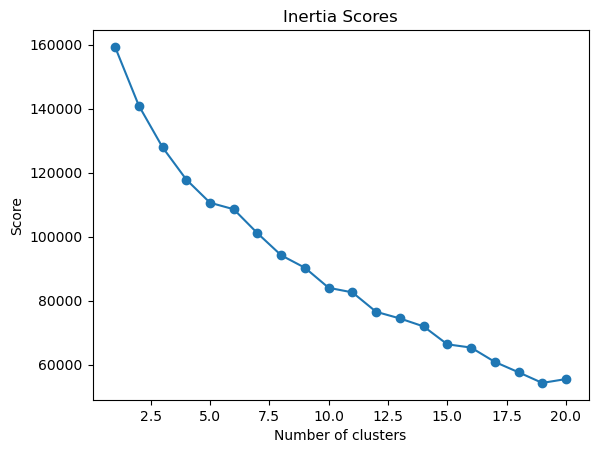

In [21]:
# plot inertia scores based on number of clusters
plt.plot(range(1, 21), inertia_list, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

In [22]:
# fit model for k = 10 and display silhouette score for comparison to DBSCAN
kmeans_10 = KMeans(n_clusters=10, n_init = 10, random_state=42)
kmeans_10.fit(X_scaled)
silhouette_score(X_scaled, kmeans_10.labels_)

0.2584252079420501

In [23]:
# instantiate and fit DBSCAN
dbscan = DBSCAN()

dbscan.fit(X_scaled);

In [24]:
# show DBSCAN labels
dbscan.labels_

array([ 0,  0,  1, ..., -1, -1, -1])

In [25]:
# get silhouette score of DBSCAN
silhouette_score(X_scaled, dbscan.labels_)

0.0901663978607581

In [26]:
# add a cluster column to data frame
sf_dev_num_1['cluster'] = dbscan.labels_

In [27]:
# show values counts of clusters
sf_dev_num_1['cluster'].value_counts()

-1     983
 0     451
 6     348
 8     346
 7     227
 2     203
 5     124
 4      81
 14     72
 3      42
 38     25
 9      23
 27     19
 36     15
 21     14
 31     14
 32     13
 20     11
 16     11
 28     11
 17     10
 13      9
 41      9
 39      8
 37      8
 22      7
 18      7
 26      7
 10      7
 1       7
 11      7
 33      6
 12      6
 15      6
 40      6
 24      5
 30      5
 29      5
 19      5
 34      5
 25      5
 42      5
 23      4
 35      4
Name: cluster, dtype: int64

At first glance, we can see that in our K-Means clustering there is no clear elbow point at which the number of clusters has a diminishing returns of inertia scores. There may be a small inflection point around 8 clusters, but the steepness of the line does not decrease substantially. In addition, when checking the silhouette score at 10 clusters, we have a score of approximately 0.26, which is not particularly compelling in terms of cluster distinction. Part of the rationale behind this clustering of 10 is that most political districting in San Franscisco is on the order of 10-15 such as supervisorial districts (11) or police districts (10). Therefore, around 10 clusters makes sense for comparing later when we use districting or neighborhood categorical data in our clustering models moving foward. Moving on, when we conducted a DBSCAN clustering model using our default parameters we did find that we got a much lower silhouette score of approximatley 0.09 than in our K-Means clustering model with 10 clusters. The DBSCAN also resulted in seemingly 42 different clusters, including 983 observations belonging to no cluster at all, the highest amount in the group of clusters.

Therefore, we shall iterate on some feature selection by dropping some features which are probably less relevant to our clustering model. First, let us try dropping all the square footage features as some of these may pertain to our mixed residential uses, but almost all pertain to our other land uses, and we can train both models again.

In [28]:
# drop extraneous columns
sf_dev_num_1.drop(columns = ['totalgsf', 
                             'netgsf', 
                             'cieexist', 
                             'cie',
                             'cienet',
                             'medexist', 
                             'med', 
                             'mednet',
                             'mipsexist',
                             'mips',
                             'mipsnet',
                             'pdrexist',
                             'pdr', 
                             'pdrnet', 
                             'retexist',
                             'ret', 
                             'retnet', 
                             'visitexist', 
                             'visit', 
                             'visitnet', 
                             'hotelroomexist',  
                             'hotelroomprop',
                             'hotelroomnet',
                             'cluster'
                            ],
                  inplace = True
                 )

In [29]:
sf_dev_num_1

units  tcocfcunits  unitsnet  pipelineunits  affordablenet  \
0        2.0          0.0       1.0            1.0            0.0   
2        1.0          0.0       1.0            1.0            0.0   
3        1.0          0.0       1.0            1.0            0.0   
4        1.0          0.0       1.0            1.0            0.0   
5        3.0          0.0       1.0            1.0            0.0   
...      ...          ...       ...            ...            ...   
39798   32.0          0.0      32.0            3.0            3.0   
39960    2.0          0.0       2.0            3.0            0.0   
40981    3.0          0.0       1.0            3.0            0.0   
41190    0.0          0.0       0.0            3.0           -1.0   
41213    2.0          0.0      -1.0            3.0            0.0   

       legalization  adu   longitude   latitude  affordable  ...  \
0               0.0  0.0 -122.508817  37.772600         0.0  ...   
2               0.0  0.0 -122.388080  37.718621         0.0  ...   
3               0.0  0.0 -122.433855  37.736508         0.0  ...   
4               0.0  0.0 -122.441421  37.735635         0.0  ...   
5               0.0  0.0 -122.467736  37.779177         0.0  ...   
...             ...  ...         ...        ...         ...  ...   
39798           0.0  0.0 -122.413437  37.773650         3.0  ...   
39960           0.0  0.0 -122.413614  37.738773         0.0  ...   
40981           0.0  0.0 -122.430431  37.751269         0.0  ...   
41190           0.0  0.0 -122.421392  37.767205         0.0  ...   
41213           0.0  0.0 -122.436087  37.796726         0.0  ...   

       beststat_BP ISSUED  beststat_BP REINSTATED  beststat_CONSTRUCTION  \
0                     0.0                     0.0                    1.0   
2                     0.0                     0.0                    1.0   
3                     0.0                     0.0                    0.0   
4                     1.0                     0.0                    0.0   
5                     0.0                     0.0                    1.0   
...                   ...                     ...                    ...   
39798                 0.0                     0.0                    1.0   
39960                 0.0                     0.0                    1.0   
40981                 0.0                     0.0                    0.0   
41190                 1.0                     0.0                    0.0   
41213                 0.0                     0.0                    0.0   

       beststat_PL APPROVED  beststat_PL FILED  \
0                       0.0                0.0   
2                       0.0                0.0   
3                       0.0                0.0   
4                       0.0                0.0   
5                       0.0                0.0   
...                     ...                ...   
39798                   0.0                0.0   
39960                   0.0                0.0   
40981                   0.0                0.0   
41190                   0.0                0.0   
41213                   0.0                0.0   

       afftarget_Extremely Very Low Income  afftarget_Low Income  \
0                                      0.0                   0.0   
2                                      0.0                   0.0   
3                                      0.0                   0.0   
4                                      0.0                   0.0   
5                                      0.0                   0.0   
...                                    ...                   ...   
39798                                  0.0                   0.0   
39960                                  0.0                   0.0   
40981                                  0.0                   0.0   
41190                                  0.0                   0.0   
41213                                  0.0                   0.0   

       afftarget_Moderate Inco

In [30]:
# define X
X = sf_dev_num_1

In [31]:
# instantiate standard scale and fit and transform X variable
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [32]:
# iterate through 20 values of k and append inertia score to a list
inertia_list =[]

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[92394.00000000003,
 82183.00812082173,
 73277.8268550153,
 66067.22671373707,
 62165.99031774254,
 60235.08056340738,
 55148.807078773345,
 52744.69688857561,
 48305.34785722854,
 45119.734010574204,
 42703.334413762146,
 39036.935065211685,
 36167.364511592976,
 34063.695882487285,
 30157.988940091207,
 29057.967080764043,
 26624.116097226273,
 24580.817420091036,
 23897.500838485903,
 22022.32903855104]

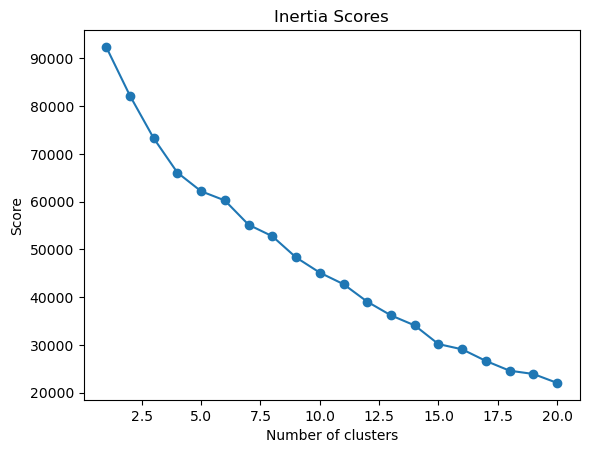

In [33]:
# plot inertia scores based on number of clusters
plt.plot(range(1, 21), inertia_list, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

In [34]:
# fit model for k = 10 and display silhouette score for comparison to DBSCAN
kmeans_10 = KMeans(n_clusters=10, n_init = 10, random_state=42)
kmeans_10.fit(X_scaled)
silhouette_score(X_scaled, kmeans_10.labels_)

0.26644274899131404

In [35]:
# instantiate and fit DBSCAN
dbscan = DBSCAN()

dbscan.fit(X_scaled);

In [36]:
# get silhouette score of DBSCAN
silhouette_score(X_scaled, dbscan.labels_)

0.14249004934377776

In [37]:
# add a cluster column to data frame
sf_dev_num_1['cluster'] = dbscan.labels_

In [38]:
# show values counts of clusters
sf_dev_num_1['cluster'].value_counts()

-1     843
 0     457
 6     351
 8     346
 7     228
 2     210
 5     127
 4      81
 14     72
 41     58
 37     44
 3      42
 38     39
 9      23
 27     19
 21     15
 39     14
 31     14
 32     13
 28     11
 20     11
 16     11
 17     10
 13      9
 11      7
 1       7
 22      7
 10      7
 44      7
 18      7
 26      7
 40      6
 36      6
 33      6
 12      6
 15      6
 43      6
 25      6
 46      5
 42      5
 34      5
 30      5
 29      5
 19      5
 45      5
 24      4
 23      4
 35      4
Name: cluster, dtype: int64

In our second iteration of the K-Means, we have improved somewhat in that our inertia scores have dropped from a low of 55K down to 22K. However, this is still very high and indicates a lot of overlapping clusters. Additionally, to compare our K-Means with 10 clusters we have a silhouette score of approximately 0.27, only slightly higher than our earlier score of 0.26. Our DBSCAN does not fare much better with a final silhouette score of 0.14. However, we still have 843 observations which were not fitted to any cluster, the largest in size still, and the number of clusters has blown up to 44 compared to 42 before.

In our next iteration, we shall go back to the original copy of the data frame and be more judicious in feature selection, trying to pare down extraneous features. For example, since units and net units might have considerable overlap or affordable and affordablenet, we shall only keep the net measures and eliminate the others, as they may be duplicative.

In [39]:
# drop extraneous columns
sf_dev_num_1.drop(columns = ['units',
                             'pipelineunits',
                             'tcocfcunits',
                             'legalization',
                             'adu',
                             'affordable',
                             'cluster'
                            ],
                  inplace = True
                 )

In [40]:
sf_dev_num_1

unitsnet  affordablenet   longitude   latitude  landuse_Mixres  \
0           1.0            0.0 -122.508817  37.772600             0.0   
2           1.0            0.0 -122.388080  37.718621             0.0   
3           1.0            0.0 -122.433855  37.736508             0.0   
4           1.0            0.0 -122.441421  37.735635             0.0   
5           1.0            0.0 -122.467736  37.779177             0.0   
...         ...            ...         ...        ...             ...   
39798      32.0            3.0 -122.413437  37.773650             1.0   
39960       2.0            0.0 -122.413614  37.738773             1.0   
40981       1.0            0.0 -122.430431  37.751269             1.0   
41190       0.0           -1.0 -122.421392  37.767205             1.0   
41213      -1.0            0.0 -122.436087  37.796726             1.0   

       landuse_Resident  entitled_-1  entitled_0  entitled_1  entitled_False  \
0                   1.0          0.0         0.0         1.0             0.0   
2                   1.0          0.0         0.0         1.0             0.0   
3                   1.0          0.0         0.0         1.0             0.0   
4                   1.0          0.0         0.0         1.0             0.0   
5                   1.0          0.0         0.0         1.0             0.0   
...                 ...          ...         ...         ...             ...   
39798               0.0          0.0         0.0         0.0             0.0   
39960               0.0          0.0         0.0         0.0             0.0   
40981               0.0          0.0         0.0         0.0             0.0   
41190               0.0          0.0         0.0         0.0             0.0   
41213               0.0          0.0         0.0         0.0             0.0   

       ...  beststat_BP ISSUED  beststat_BP REINSTATED  beststat_CONSTRUCTION  \
0      ...                 0.0                     0.0                    1.0   
2      ...                 0.0                     0.0                    1.0   
3      ...                 0.0                     0.0                    0.0   
4      ...                 1.0                     0.0                    0.0   
5      ...                 0.0                     0.0                    1.0   
...    ...                 ...                     ...                    ...   
39798  ...                 0.0                     0.0                    1.0   
39960  ...                 0.0                     0.0                    1.0   
40981  ...                 0.0                     0.0                    0.0   
41190  ...                 1.0                     0.0                    0.0   
41213  ...                 0.0                     0.0                    0.0   

       beststat_PL APPROVED  beststat_PL FILED  \
0                       0.0                0.0   
2                       0.0                0.0   
3                       0.0                0.0   
4                       0.0                0.0   
5                       0.0                0.0   
...                     ...                ...   
39798                   0.0                0.0   
39960                   0.0                0.0   
40981                   0.0                0.0   
41190                   0.0                0.0   
41213                   0.0                0.0   

       afftarget_Extremely Very Low Income  afftarget_Low Income  \
0                                      0.0                   0.0   
2                                      0.0                   0.0   
3                                      0.0                   0.0   
4                                      0.0                   0.0   
5                                      0.0                   0.0   
...                                    ...                   ...   
39798                                  0.0                   0.0   
39960                                  0.0         

In [41]:
# define X
X = sf_dev_num_1

In [42]:
# instantiate standard scale and fit and transform X variable
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [43]:
# iterate through 20 values of k and append inertia score to a list
inertia_list =[]

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[73277.99999999997,
 63158.82763430155,
 57443.23773567118,
 53241.65055726153,
 49827.49694923418,
 45251.9972133438,
 42543.62271295792,
 38214.38359368442,
 35045.827376414,
 31158.499652111226,
 28223.433701365826,
 25086.71238338096,
 21917.327379609927,
 19354.337519298773,
 16725.70648882738,
 15760.369037471512,
 12845.310869535522,
 12149.843400557495,
 11466.400868326176,
 10668.40343915864]

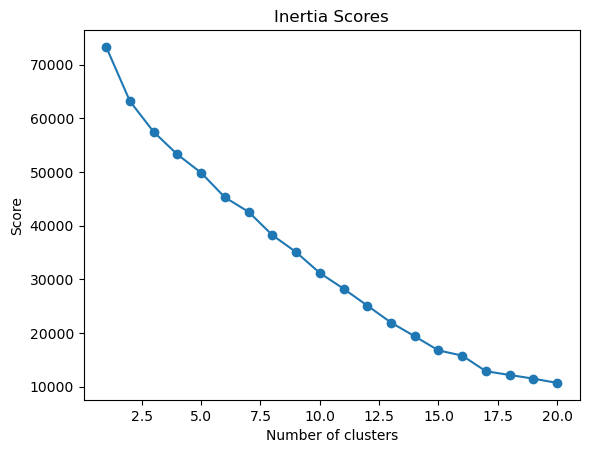

In [44]:
# plot inertia scores based on number of clusters
plt.plot(range(1, 21), inertia_list, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

In [45]:
# fit model for k = 10 and display silhouette score for comparison to DBSCAN
kmeans_10 = KMeans(n_clusters=10, n_init = 10, random_state=42)
kmeans_10.fit(X_scaled)
silhouette_score(X_scaled, kmeans_10.labels_)

0.4019744834500955

In [46]:
# instantiate and fit DBSCAN
dbscan = DBSCAN()

dbscan.fit(X_scaled);

In [47]:
# get silhouette score of DBSCAN
silhouette_score(X_scaled, dbscan.labels_)

0.3108081039383761

In [48]:
# add a cluster column to data frame
sf_dev_num_1['kmeans_cluster'] = kmeans_10.labels_

In [49]:
# show values counts of clusters
sf_dev_num_1['kmeans_cluster'].value_counts()

1    1106
2    1045
5     406
3     318
0     217
4      41
6      39
8       9
9       3
7       2
Name: kmeans_cluster, dtype: int64

In [50]:
# add a cluster column to data frame
sf_dev_num_1['dbscan_cluster'] = dbscan.labels_

In [51]:
# show values counts of clusters
sf_dev_num_1['dbscan_cluster'].value_counts()

 3     926
 0     791
-1     527
 2     278
 4     238
 24    111
 21     60
 22     42
 23     35
 1      25
 9      14
 10     11
 19     10
 5      10
 8      10
 27      9
 26      9
 7       9
 20      7
 6       7
 25      7
 14      7
 17      6
 16      6
 15      6
 18      6
 12      6
 11      5
 28      5
 13      3
Name: dbscan_cluster, dtype: int64

Our dimensional reduction and feature selection has done well to improve inertia scores and silhouette scores, and our DBSCAN includes substantially less clusters at 27. However, with a K-Means minimum inertia score at ~11K, we still have a lot of progress which could be made. The good news is that the silhouette score for the K-Means with 10 clusters is now at approximately 0.40 which is an improvement in more distinct clusters. Our DBSCAN silhouette score has also improved up to approximately 0.31, but 27 clusters is still a lot and 527 observations remain not belonging to any cluster.

---

## Categorical Features Clustering Model Tuning

In this section, we shall now return to make a second copy of our original data frame and drop many of the numerical features. We shall stick to political districting data for our main original features as our main categorical features and then do feature selection.

In [52]:
sf_dev_geo = sf_dev_projs.copy()

In [53]:
# drop extraneous columns
sf_dev_geo.drop(columns = ['units',
                           'pipelineunits',
                           'tcocfcunits',
                           'legalization',
                           'adu',
                           'affordable',
                           'totalgsf',
                           'netgsf', 
                           'cieexist', 
                           'cie',
                           'cienet',
                           'medexist', 
                           'med',
                           'mednet',
                           'mipsexist',
                           'mips',
                           'mipsnet',
                           'pdrexist',
                           'pdr', 
                           'pdrnet', 
                           'retexist',
                           'ret', 
                           'retnet', 
                           'visitexist',
                           'visit', 
                           'visitnet', 
                           'hotelroomexist',  
                           'hotelroomprop',
                           'hotelroomnet'
                            ],
                  inplace = True
                 )

In [54]:
sf_dev_geo

landuse entitled      beststat  unitsnet  affordablenet  \
0      Resident        1  CONSTRUCTION       1.0            0.0   
2      Resident        1  CONSTRUCTION       1.0            0.0   
3      Resident        1   BP APPROVED       1.0            0.0   
4      Resident        1     BP ISSUED       1.0            0.0   
5      Resident        1  CONSTRUCTION       1.0            0.0   
...         ...      ...           ...       ...            ...   
39798    Mixres     True  CONSTRUCTION      32.0            3.0   
39960    Mixres     True  CONSTRUCTION       2.0            0.0   
40981    Mixres     True   BP APPROVED       1.0            0.0   
41190    Mixres     True     BP ISSUED       0.0           -1.0   
41213    Mixres     True      BP FILED      -1.0            0.0   

                   afftarget                   pd  sd22  \
0      No Affordable Housing         1 - Richmond   1.0   
2      No Affordable Housing  10 - South Bayshore  10.0   
3      No Affordable Housing          7 - Central   8.0   
4      No Affordable Housing       13 - Ingleside   7.0   
5      No Affordable Housing         1 - Richmond   1.0   
...                      ...                  ...   ...   
39798  No Affordable Housing  9 - South of Market   6.0   
39960  No Affordable Housing  11 - Bernal Heights   9.0   
40981  No Affordable Housing          7 - Central   8.0   
41190  No Affordable Housing          8 - Mission   9.0   
41213  No Affordable Housing           2 - Marina   2.0   

                     nhood41   zoning heightbul  \
0             Outer Richmond     RH-2      40-X   
2      Bayview Hunters Point     RH-1      40-X   
3                  Glen Park     RH-1      40-X   
4         West of Twin Peaks     RH-1      40-X   
5             Inner Richmond     RM-1      40-X   
...                      ...      ...       ...   
39798                Unknown  Unknown   Unknown   
39960                Unknown  Unknown   Unknown   
40981                Unknown  Unknown   Unknown   
41190                Unknown  Unknown   Unknown   
41213                Unknown  Unknown   Unknown   

                                   pda   longitude   latitude  \
0                   Richmond Corridors -122.508817  37.772600   
2      Bayview/Southeast Neighborhoods -122.388080  37.718621   
3        J Church and Mission Corridor -122.433855  37.736508   
4                                    0 -122.441421  37.735635   
5                   Richmond Corridors -122.467736  37.779177   
...                                ...         ...        ...   
39798                   Not applicable -122.413437  37.773650   
39960                   Not applicable -122.413614  37.738773   
40981                   Not applicable -122.430431  37.751269   
41190                   Not applicable -122.421392  37.767205   
41213                   Not applicable -122.436087  37.796726   

      currentpolicedistricts  
0                        8.0  
2                        2.0  
3                        9.0  
4                        9.0  
5                        8.0  
...                      ...  
39798                    1.0  
39960                    9.0  
40981                    3.0  
41190                    3.0  
41213                    4.0  

[3186 rows x 15 columns]

In [55]:
# create one hot encoded variable for categorical data
sf_dev_geo_1 = pd.get_dummies(sf_dev_geo).astype(float)

In [56]:
sf_dev_geo_1

unitsnet  affordablenet  sd22   longitude   latitude  landuse_Mixres  \
0           1.0            0.0   1.0 -122.508817  37.772600             0.0   
2           1.0            0.0  10.0 -122.388080  37.718621             0.0   
3           1.0            0.0   8.0 -122.433855  37.736508             0.0   
4           1.0            0.0   7.0 -122.441421  37.735635             0.0   
5           1.0            0.0   1.0 -122.467736  37.779177             0.0   
...         ...            ...   ...         ...        ...             ...   
39798      32.0            3.0   6.0 -122.413437  37.773650             1.0   
39960       2.0            0.0   9.0 -122.413614  37.738773             1.0   
40981       1.0            0.0   8.0 -122.430431  37.751269             1.0   
41190       0.0           -1.0   9.0 -122.421392  37.767205             1.0   
41213      -1.0            0.0   2.0 -122.436087  37.796726             1.0   

       landuse_Resident  entitled_-1  entitled_0  entitled_1  ...  \
0                   1.0          0.0         0.0         1.0  ...   
2                   1.0          0.0         0.0         1.0  ...   
3                   1.0          0.0         0.0         1.0  ...   
4                   1.0          0.0         0.0         1.0  ...   
5                   1.0          0.0         0.0         1.0  ...   
...                 ...          ...         ...         ...  ...   
39798               0.0          0.0         0.0         0.0  ...   
39960               0.0          0.0         0.0         0.0  ...   
40981               0.0          0.0         0.0         0.0  ...   
41190               0.0          0.0         0.0         0.0  ...   
41213               0.0          0.0         0.0         0.0  ...   

       currentpolicedistricts_10.0  currentpolicedistricts_2.0  \
0                              0.0                         0.0   
2                              0.0                         1.0   
3                              0.0                         0.0   
4                              0.0                         0.0   
5                              0.0                         0.0   
...                            ...                         ...   
39798                          0.0                         0.0   
39960                          0.0                         0.0   
40981                          0.0                         0.0   
41190                          0.0                         0.0   
41213                          0.0                         0.0   

       currentpolicedistricts_3.0  currentpolicedistricts_4.0  \
0                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
5                             0.0                         0.0   
...                           ...                         ...   
39798                         0.0                         0.0   
39960                         0.0                         0.0   
40981                         1.0                         0.0   
41190                         1.0                         0.0   
41213                         0.0                         1.0   

       currentpolicedistricts_5.0  currentpolicedistricts_6.0  \
0                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
5                             0.0                         0.0   
...                           ...                         ...   
39798                         0.0                         0.0   
39960                         0.0                         0.0   
40981                         0.0                         0.0   
41190

In [57]:
# define X
X = sf_dev_geo_1

In [58]:
# instantiate standard scale and fit and transform X variable
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [59]:
# iterate through 20 values of k and append inertia score to a list
inertia_list =[]

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[1115099.9999999998,
 1096986.2688858747,
 1086397.5765742783,
 1070827.5711354944,
 1066039.5186303472,
 1054982.0000205014,
 1039819.0043010536,
 1031137.3443795324,
 1019867.8869229988,
 1011213.712178258,
 999607.3827471029,
 1003802.4022831145,
 979102.6885047348,
 978780.2884357199,
 968740.8284890722,
 962399.2368944865,
 958103.2397252549,
 949987.3188786014,
 951515.2256492875,
 934467.6331630696]

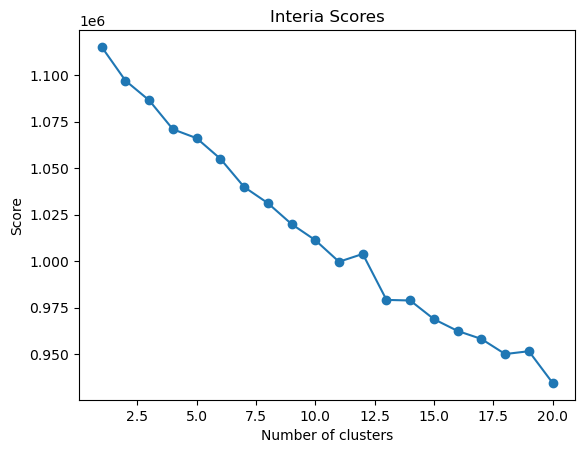

In [60]:
# plot inertia scores based on number of clusters
plt.plot(range(1, 21), inertia_list, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Interia Scores');

In [61]:
# fit model for k = 10 and display silhouette score for comparison to DBSCAN
kmeans_10 = KMeans(n_clusters=10, n_init = 10, random_state=42)
kmeans_10.fit(X_scaled)
silhouette_score(X_scaled, kmeans_10.labels_)

-0.0012380626844213482

In [62]:
# instantiate and fit DBSCAN
dbscan = DBSCAN()

dbscan.fit(X_scaled);

In [63]:
# get silhouette score of DBSCAN
silhouette_score(X_scaled, dbscan.labels_)

-0.07523411441978649

In [64]:
# add a cluster column to data frame
sf_dev_geo_1['dbscan_cluster'] = dbscan.labels_

In [65]:
# show values counts of clusters
sf_dev_geo_1['dbscan_cluster'].value_counts()

-1     2295
 5       45
 33      41
 30      37
 43      37
       ... 
 31       5
 70       5
 65       5
 69       5
 68       5
Name: dbscan_cluster, Length: 87, dtype: int64

As suspected, when we one hot encoded all the categorical features we went from 15 columns to 350. This produced the worst clustering models so with negative silhouette scores. Based on our data cleaning, we saw that some categorical features had sso many different naming conventions or multiple categories than using the column as a feature at all may prove useless in providing any clear clustering insights. Therefore, we shall iterate by returning to the original copy of the data frame and dropping nhood41, pd, pda, heightbul, and zoning.

In [66]:
# drop extraneous columns
sf_dev_geo.drop(columns = ['nhood41',
                           'pd',
                           'pda',
                           'heightbul',
                           'zoning'
                            ],
                  inplace = True
                 )

In [67]:
sf_dev_geo

landuse entitled      beststat  unitsnet  affordablenet  \
0      Resident        1  CONSTRUCTION       1.0            0.0   
2      Resident        1  CONSTRUCTION       1.0            0.0   
3      Resident        1   BP APPROVED       1.0            0.0   
4      Resident        1     BP ISSUED       1.0            0.0   
5      Resident        1  CONSTRUCTION       1.0            0.0   
...         ...      ...           ...       ...            ...   
39798    Mixres     True  CONSTRUCTION      32.0            3.0   
39960    Mixres     True  CONSTRUCTION       2.0            0.0   
40981    Mixres     True   BP APPROVED       1.0            0.0   
41190    Mixres     True     BP ISSUED       0.0           -1.0   
41213    Mixres     True      BP FILED      -1.0            0.0   

                   afftarget  sd22   longitude   latitude  \
0      No Affordable Housing   1.0 -122.508817  37.772600   
2      No Affordable Housing  10.0 -122.388080  37.718621   
3      No Affordable Housing   8.0 -122.433855  37.736508   
4      No Affordable Housing   7.0 -122.441421  37.735635   
5      No Affordable Housing   1.0 -122.467736  37.779177   
...                      ...   ...         ...        ...   
39798  No Affordable Housing   6.0 -122.413437  37.773650   
39960  No Affordable Housing   9.0 -122.413614  37.738773   
40981  No Affordable Housing   8.0 -122.430431  37.751269   
41190  No Affordable Housing   9.0 -122.421392  37.767205   
41213  No Affordable Housing   2.0 -122.436087  37.796726   

      currentpolicedistricts  
0                        8.0  
2                        2.0  
3                        9.0  
4                        9.0  
5                        8.0  
...                      ...  
39798                    1.0  
39960                    9.0  
40981                    3.0  
41190                    3.0  
41213                    4.0  

[3186 rows x 10 columns]

In [68]:
# create one hot encoded variable for categorical data
sf_dev_geo_2 = pd.get_dummies(sf_dev_geo).astype(float)

In [69]:
sf_dev_geo_2

unitsnet  affordablenet  sd22   longitude   latitude  landuse_Mixres  \
0           1.0            0.0   1.0 -122.508817  37.772600             0.0   
2           1.0            0.0  10.0 -122.388080  37.718621             0.0   
3           1.0            0.0   8.0 -122.433855  37.736508             0.0   
4           1.0            0.0   7.0 -122.441421  37.735635             0.0   
5           1.0            0.0   1.0 -122.467736  37.779177             0.0   
...         ...            ...   ...         ...        ...             ...   
39798      32.0            3.0   6.0 -122.413437  37.773650             1.0   
39960       2.0            0.0   9.0 -122.413614  37.738773             1.0   
40981       1.0            0.0   8.0 -122.430431  37.751269             1.0   
41190       0.0           -1.0   9.0 -122.421392  37.767205             1.0   
41213      -1.0            0.0   2.0 -122.436087  37.796726             1.0   

       landuse_Resident  entitled_-1  entitled_0  entitled_1  ...  \
0                   1.0          0.0         0.0         1.0  ...   
2                   1.0          0.0         0.0         1.0  ...   
3                   1.0          0.0         0.0         1.0  ...   
4                   1.0          0.0         0.0         1.0  ...   
5                   1.0          0.0         0.0         1.0  ...   
...                 ...          ...         ...         ...  ...   
39798               0.0          0.0         0.0         0.0  ...   
39960               0.0          0.0         0.0         0.0  ...   
40981               0.0          0.0         0.0         0.0  ...   
41190               0.0          0.0         0.0         0.0  ...   
41213               0.0          0.0         0.0         0.0  ...   

       currentpolicedistricts_10.0  currentpolicedistricts_2.0  \
0                              0.0                         0.0   
2                              0.0                         1.0   
3                              0.0                         0.0   
4                              0.0                         0.0   
5                              0.0                         0.0   
...                            ...                         ...   
39798                          0.0                         0.0   
39960                          0.0                         0.0   
40981                          0.0                         0.0   
41190                          0.0                         0.0   
41213                          0.0                         0.0   

       currentpolicedistricts_3.0  currentpolicedistricts_4.0  \
0                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
5                             0.0                         0.0   
...                           ...                         ...   
39798                         0.0                         0.0   
39960                         0.0                         0.0   
40981                         1.0                         0.0   
41190                         1.0                         0.0   
41213                         0.0                         1.0   

       currentpolicedistricts_5.0  currentpolicedistricts_6.0  \
0                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
5                             0.0                         0.0   
...                           ...                         ...   
39798                         0.0                         0.0   
39960                         0.0                         0.0   
40981                         0.0                         0.0   
41190

In [70]:
# define X
X = sf_dev_geo_2

In [71]:
# instantiate standard scale and fit and transform X variable
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [72]:
# iterate through 20 values of k and append inertia score to a list
inertia_list =[]

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[111510.00000000001,
 101355.14902227459,
 94299.86880411606,
 89706.83447786662,
 87343.58351209755,
 82493.60840649539,
 79873.61644508787,
 77202.75292827254,
 72839.00364087852,
 69006.49831933522,
 64996.014364615454,
 63495.89613851519,
 59561.40515310862,
 56976.541086324345,
 53394.64262433313,
 50292.60840374816,
 47247.668148116325,
 44267.67621126582,
 43888.08473516699,
 42480.57020863189]

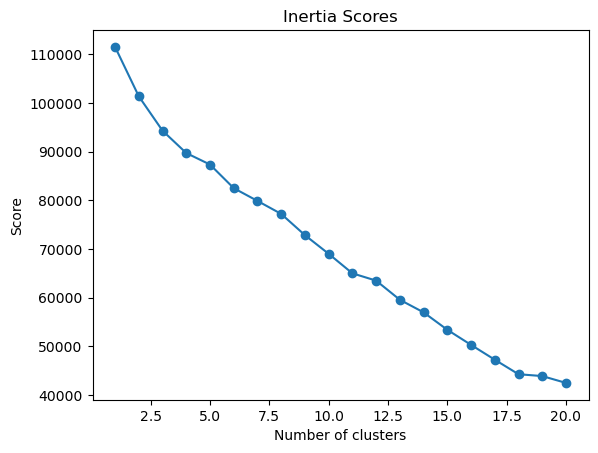

In [73]:
# plot inertia scores based on number of clusters
plt.plot(range(1, 21), inertia_list, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

In [74]:
# fit model for k = 10 and display silhouette score for comparison to DBSCAN
kmeans_10 = KMeans(n_clusters=10, n_init = 10, random_state=42)
kmeans_10.fit(X_scaled)
silhouette_score(X_scaled, kmeans_10.labels_)

0.17863836354489

In [75]:
# instantiate and fit DBSCAN
dbscan = DBSCAN()

dbscan.fit(X_scaled);

In [76]:
# get silhouette score of DBSCAN
silhouette_score(X_scaled, dbscan.labels_)

0.41463176417491193

In [77]:
# add a cluster column to data frame
sf_dev_geo_2['kmeans_cluster'] = kmeans_10.labels_

In [78]:
# show values counts of clusters
sf_dev_geo_2['kmeans_cluster'].value_counts()

7    1079
6     578
1     468
3     448
0     346
2     176
8      41
5      39
4       9
9       2
Name: kmeans_cluster, dtype: int64

In [79]:
# add a cluster column to data frame
sf_dev_geo_2['dbscan_cluster'] = dbscan.labels_

In [80]:
# show values counts of clusters
sf_dev_geo_2['dbscan_cluster'].value_counts()

-1     735
 23    125
 5     118
 0     107
 27    106
      ... 
 94      5
 91      5
 92      5
 87      5
 73      3
Name: dbscan_cluster, Length: 97, dtype: int64

Unsurprisingly, with our features reduced down to 35 from 350, we have massive improvement in inertia scores and silhouette scores, with a K-Means with 10 clusters having a silhouette score of approximately 0.18 and the DBSCAN having a silhouette score of approximately 0.41 albeit with over 90 cluster and 735 observations still belonging to no cluster. We can now use features from numerical and categorical feature iterations to arrive at our production model.

---

## Clustering Production Model & EDA

We shall use the best features of both our numerical and categorical variables in one final attempt to get one final production model for clustering. We shall temporarily drop latitude and longitude from our variables since political districts may act as a sufficient proxy for geography and neighborhoods, and we will use coordinates for our exploratory data analysis in our production model. Additionally, we will attempt to eliminate a few more extraneous features which we did not investigate during our initial data analysis such as entitled.

In [81]:
sf_dev_final = sf_dev_projs.copy()

In [82]:
sf_dev_final

landuse entitled      beststat  units  tcocfcunits  unitsnet  \
0      Resident        1  CONSTRUCTION    2.0          0.0       1.0   
2      Resident        1  CONSTRUCTION    1.0          0.0       1.0   
3      Resident        1   BP APPROVED    1.0          0.0       1.0   
4      Resident        1     BP ISSUED    1.0          0.0       1.0   
5      Resident        1  CONSTRUCTION    3.0          0.0       1.0   
...         ...      ...           ...    ...          ...       ...   
39798    Mixres     True  CONSTRUCTION   32.0          0.0      32.0   
39960    Mixres     True  CONSTRUCTION    2.0          0.0       2.0   
40981    Mixres     True   BP APPROVED    3.0          0.0       1.0   
41190    Mixres     True     BP ISSUED    0.0          0.0       0.0   
41213    Mixres     True      BP FILED    2.0          0.0      -1.0   

       pipelineunits  affordablenet              afftarget  totalgsf  ...  \
0                1.0            0.0  No Affordable Housing       0.0  ...   
2                1.0            0.0  No Affordable Housing       0.0  ...   
3                1.0            0.0  No Affordable Housing       0.0  ...   
4                1.0            0.0  No Affordable Housing       0.0  ...   
5                1.0            0.0  No Affordable Housing       0.0  ...   
...              ...            ...                    ...       ...  ...   
39798            3.0            3.0  No Affordable Housing    1813.0  ...   
39960            3.0            0.0  No Affordable Housing     150.0  ...   
40981            3.0            0.0  No Affordable Housing    1808.0  ...   
41190            3.0           -1.0  No Affordable Housing   12900.0  ...   
41213            3.0            0.0  No Affordable Housing    1480.0  ...   

                        pd  sd22                nhood41   zoning  heightbul  \
0             1 - Richmond   1.0         Outer Richmond     RH-2       40-X   
2      10 - South Bayshore  10.0  Bayview Hunters Point     RH-1       40-X   
3              7 - Central   8.0              Glen Park     RH-1       40-X   
4           13 - Ingleside   7.0     West of Twin Peaks     RH-1       40-X   
5             1 - Richmond   1.0         Inner Richmond     RM-1       40-X   
...                    ...   ...                    ...      ...        ...   
39798  9 - South of Market   6.0                Unknown  Unknown    Unknown   
39960  11 - Bernal Heights   9.0                Unknown  Unknown    Unknown   
40981          7 - Central   8.0                Unknown  Unknown    Unknown   
41190          8 - Mission   9.0                Unknown  Unknown    Unknown   
41213           2 - Marina   2.0                Unknown  Unknown    Unknown   

                                   pda   longitude   latitude  \
0                   Richmond Corridors -122.508817  37.772600   
2      Bayview/Southeast Neighborhoods -122.388080  37.718621   
3        J Church and Mission Corridor -122.433855  37.736508   
4                                    0 -122.441421  37.735635   
5                   Richmond Corridors -122.467736  37.779177   
...                                ...         ...        ...   
39798                   Not applicable -122.413437  37.773650   
39960                   Not applicable -122.413614  37.738773   
40981                   Not applicable -122.430431  37.751269   
41190                   Not applicable -122.421392  37.767205   
41213                   Not applicable -122.436087  37.796726   

       currentpolicedistricts  affordable  
0                         8.0         0.0  
2                         2.0         0.0  
3                         9.0         0.0  
4                         9.0         0.0  
5                         8.0         0.0  
...                       ...         ...  
39798                     1.0         3.0  
39960                     9.0         0.0  
40981                     3.0         0.0  
41190                     3.0         0.0  
4121

In [83]:
# drop extraneous columns
sf_dev_final.drop(columns = ['units',
                           'pipelineunits',
                           'tcocfcunits',
                           'legalization',
                           'adu',
                           'affordable',
                           'totalgsf',
                           'netgsf', 
                           'cieexist', 
                           'cie',
                           'cienet',
                           'medexist', 
                           'med',
                           'mednet',
                           'mipsexist',
                           'mips',
                           'mipsnet',
                           'pdrexist',
                           'pdr', 
                           'pdrnet', 
                           'retexist',
                           'ret', 
                           'retnet', 
                           'visitexist',
                           'visit', 
                           'visitnet', 
                           'hotelroomexist',  
                           'hotelroomprop',
                           'hotelroomnet',
                           'nhood41',
                           'pd',
                           'pda',
                           'heightbul',
                           'zoning',
                           'entitled'
                            ],
                  inplace = True
                 )

In [84]:
sf_dev_final

landuse      beststat  unitsnet  affordablenet              afftarget  \
0      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
2      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
3      Resident   BP APPROVED       1.0            0.0  No Affordable Housing   
4      Resident     BP ISSUED       1.0            0.0  No Affordable Housing   
5      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
...         ...           ...       ...            ...                    ...   
39798    Mixres  CONSTRUCTION      32.0            3.0  No Affordable Housing   
39960    Mixres  CONSTRUCTION       2.0            0.0  No Affordable Housing   
40981    Mixres   BP APPROVED       1.0            0.0  No Affordable Housing   
41190    Mixres     BP ISSUED       0.0           -1.0  No Affordable Housing   
41213    Mixres      BP FILED      -1.0            0.0  No Affordable Housing   

       sd22   longitude   latitude currentpolicedistricts  
0       1.0 -122.508817  37.772600                    8.0  
2      10.0 -122.388080  37.718621                    2.0  
3       8.0 -122.433855  37.736508                    9.0  
4       7.0 -122.441421  37.735635                    9.0  
5       1.0 -122.467736  37.779177                    8.0  
...     ...         ...        ...                    ...  
39798   6.0 -122.413437  37.773650                    1.0  
39960   9.0 -122.413614  37.738773                    9.0  
40981   8.0 -122.430431  37.751269                    3.0  
41190   9.0 -122.421392  37.767205                    3.0  
41213   2.0 -122.436087  37.796726                    4.0  

[3186 rows x 9 columns]

In [85]:
# create one hot encoded variable for categorical data
sf_dev_final_1 = pd.get_dummies(sf_dev_final).astype(float)

In [86]:
sf_dev_final_1

unitsnet  affordablenet  sd22   longitude   latitude  landuse_Mixres  \
0           1.0            0.0   1.0 -122.508817  37.772600             0.0   
2           1.0            0.0  10.0 -122.388080  37.718621             0.0   
3           1.0            0.0   8.0 -122.433855  37.736508             0.0   
4           1.0            0.0   7.0 -122.441421  37.735635             0.0   
5           1.0            0.0   1.0 -122.467736  37.779177             0.0   
...         ...            ...   ...         ...        ...             ...   
39798      32.0            3.0   6.0 -122.413437  37.773650             1.0   
39960       2.0            0.0   9.0 -122.413614  37.738773             1.0   
40981       1.0            0.0   8.0 -122.430431  37.751269             1.0   
41190       0.0           -1.0   9.0 -122.421392  37.767205             1.0   
41213      -1.0            0.0   2.0 -122.436087  37.796726             1.0   

       landuse_Resident  beststat_BP APPROVED  beststat_BP FILED  \
0                   1.0                   0.0                0.0   
2                   1.0                   0.0                0.0   
3                   1.0                   1.0                0.0   
4                   1.0                   0.0                0.0   
5                   1.0                   0.0                0.0   
...                 ...                   ...                ...   
39798               0.0                   0.0                0.0   
39960               0.0                   0.0                0.0   
40981               0.0                   1.0                0.0   
41190               0.0                   0.0                0.0   
41213               0.0                   0.0                1.0   

       beststat_BP ISSUED  ...  currentpolicedistricts_10.0  \
0                     0.0  ...                          0.0   
2                     0.0  ...                          0.0   
3                     0.0  ...                          0.0   
4                     1.0  ...                          0.0   
5                     0.0  ...                          0.0   
...                   ...  ...                          ...   
39798                 0.0  ...                          0.0   
39960                 0.0  ...                          0.0   
40981                 0.0  ...                          0.0   
41190                 1.0  ...                          0.0   
41213                 0.0  ...                          0.0   

       currentpolicedistricts_2.0  currentpolicedistricts_3.0  \
0                             0.0                         0.0   
2                             1.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
5                             0.0                         0.0   
...                           ...                         ...   
39798                         0.0                         0.0   
39960                         0.0                         0.0   
40981                         0.0                         1.0   
41190                         0.0                         1.0   
41213                         0.0                         0.0   

       currentpolicedistricts_4.0  currentpolicedistricts_5.0  \
0                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
5                             0.0                         0.0   
...                           ...                         ...   
39798                         0.0                         0.0   
39960                         0.0                         0.0   
40981                         0.0                         0.0   
41190                         0.0                    

In [87]:
# define X
X = sf_dev_final_1.drop(columns = ['longitude', 'latitude'])

In [88]:
# instantiate standard scale and fit and transform X variable
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [89]:
# iterate through 20 values of k and append inertia score to a list
inertia_list =[]

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[89207.99999999999,
 81599.53731426926,
 77167.55299250405,
 74011.72015207156,
 70091.32847308838,
 67142.04521851733,
 63648.109490988936,
 58375.205548211496,
 55525.89367949405,
 51778.870508507265,
 48004.79654617553,
 44156.691551344215,
 41297.78769125812,
 37218.712339772974,
 34252.18623082404,
 31418.19136639485,
 29026.780819933003,
 27286.36169894118,
 27438.930231305698,
 24490.017368707748]

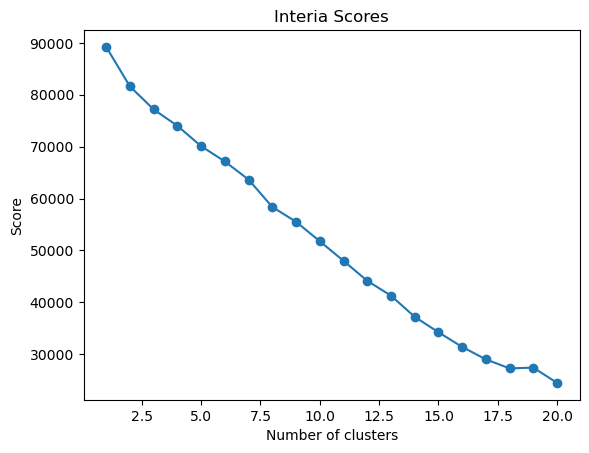

In [90]:
# plot inertia scores based on number of clusters
plt.plot(range(1, 21), inertia_list, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Interia Scores');

In [91]:
# fit model for k = 10 and display silhouette score for comparison to DBSCAN
kmeans_10 = KMeans(n_clusters=10, n_init = 10, random_state=42)
kmeans_10.fit(X_scaled)
silhouette_score(X_scaled, kmeans_10.labels_)

0.2993022373051002

In [92]:
# instantiate and fit DBSCAN
dbscan = DBSCAN()

dbscan.fit(X_scaled);

In [93]:
# get silhouette score of DBSCAN
silhouette_score(X_scaled, dbscan.labels_)

0.7542941215403887

In [94]:
# add a cluster column to data frame
sf_dev_final_1['kmeans_cluster'] = kmeans_10.labels_

In [95]:
# show values counts of clusters
sf_dev_final_1['kmeans_cluster'].value_counts()

7    578
3    576
1    560
4    405
6    347
9    260
0    241
2    176
5     41
8      2
Name: kmeans_cluster, dtype: int64

In [96]:
# add a cluster column to data frame
sf_dev_final_1['dbscan_cluster'] = dbscan.labels_

In [97]:
# show values counts of clusters
sf_dev_final_1['dbscan_cluster'].value_counts()

-1     386
 13    194
 15    171
 23    141
 0     118
      ... 
 93      5
 94      5
 66      5
 8       5
 64      5
Name: dbscan_cluster, Length: 99, dtype: int64

This iteration of our final production model has produced the best silhouette scores so far, with approximately 0.30 in our K-Means with 10 clusters and approximately 0.75 in our DBSCAN. The DBSCAN is still producing over 90 clusters with 386 observations in no cluster. Our strictly numerical clustering model with a k value of 10 in our K-Means produced a silhouette score of ~0.40. We shall make one final attempt to iterate by eliminating the currentpolicedistrict feature since this is probably closely correlated with the supervisorial districts.

In [98]:
sf_dev_final.drop(columns = 'currentpolicedistricts', inplace = True)

In [99]:
# create one hot encoded variable for categorical data
sf_dev_final_2 = pd.get_dummies(sf_dev_final).astype(float)

In [100]:
sf_dev_final_2

unitsnet  affordablenet  sd22   longitude   latitude  landuse_Mixres  \
0           1.0            0.0   1.0 -122.508817  37.772600             0.0   
2           1.0            0.0  10.0 -122.388080  37.718621             0.0   
3           1.0            0.0   8.0 -122.433855  37.736508             0.0   
4           1.0            0.0   7.0 -122.441421  37.735635             0.0   
5           1.0            0.0   1.0 -122.467736  37.779177             0.0   
...         ...            ...   ...         ...        ...             ...   
39798      32.0            3.0   6.0 -122.413437  37.773650             1.0   
39960       2.0            0.0   9.0 -122.413614  37.738773             1.0   
40981       1.0            0.0   8.0 -122.430431  37.751269             1.0   
41190       0.0           -1.0   9.0 -122.421392  37.767205             1.0   
41213      -1.0            0.0   2.0 -122.436087  37.796726             1.0   

       landuse_Resident  beststat_BP APPROVED  beststat_BP FILED  \
0                   1.0                   0.0                0.0   
2                   1.0                   0.0                0.0   
3                   1.0                   1.0                0.0   
4                   1.0                   0.0                0.0   
5                   1.0                   0.0                0.0   
...                 ...                   ...                ...   
39798               0.0                   0.0                0.0   
39960               0.0                   0.0                0.0   
40981               0.0                   1.0                0.0   
41190               0.0                   0.0                0.0   
41213               0.0                   0.0                1.0   

       beststat_BP ISSUED  beststat_BP REINSTATED  beststat_CONSTRUCTION  \
0                     0.0                     0.0                    1.0   
2                     0.0                     0.0                    1.0   
3                     0.0                     0.0                    0.0   
4                     1.0                     0.0                    0.0   
5                     0.0                     0.0                    1.0   
...                   ...                     ...                    ...   
39798                 0.0                     0.0                    1.0   
39960                 0.0                     0.0                    1.0   
40981                 0.0                     0.0                    0.0   
41190                 1.0                     0.0                    0.0   
41213                 0.0                     0.0                    0.0   

       beststat_PL APPROVED  beststat_PL FILED  \
0                       0.0                0.0   
2                       0.0                0.0   
3                       0.0                0.0   
4                       0.0                0.0   
5                       0.0                0.0   
...                     ...                ...   
39798                   0.0                0.0   
39960                   0.0                0.0   
40981                   0.0                0.0   
41190                   0.0                0.0   
41213                   0.0                0.0   

       afftarget_Extremely Very Low Income  afftarget_Low Income  \
0                                      0.0                   0.0   
2                                      0.0                   0.0   
3                                      0.0                   0.0   
4                                      0.0                   0.0   
5                                      0.0                   0.0   
...                                    ...                   ...   
39798                                  0.0                   0.0   
39960                                  0.0                   0.0   
40981                                  0.0                   0.0   
41190                                  0.0     

In [101]:
# define X
X = sf_dev_final_2.drop(columns = ['longitude', 'latitude'])

In [102]:
# instantiate standard scale and fit and transform X variable
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [103]:
# iterate through 20 values of k and append inertia score to a list
inertia_list =[]

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[54161.999999999985,
 46887.91137560726,
 42700.867099546915,
 38683.88148796259,
 35883.583856725454,
 31670.821150489282,
 27987.379751906203,
 24002.47682943394,
 20488.05157892337,
 17239.783745225504,
 14196.865240918436,
 11167.816562639642,
 8376.093359023102,
 7604.71601352903,
 6802.9835974222215,
 6032.032702373358,
 5430.602958835052,
 4687.805945509339,
 4157.970916323654,
 3841.864248142623]

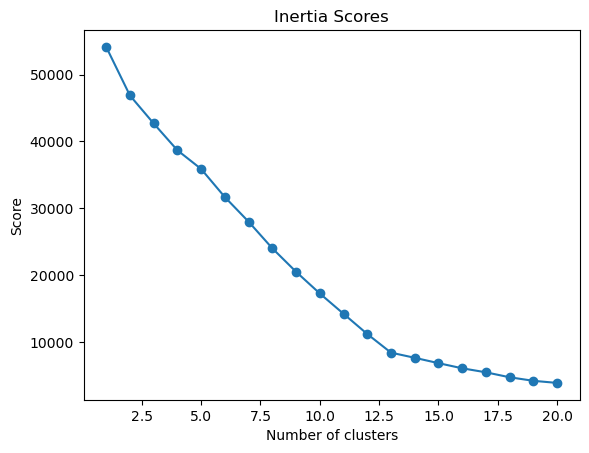

In [118]:
# plot inertia scores based on number of clusters
plt.plot(range(1, 21), inertia_list, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Inertia Scores')
plt.savefig('../images/inertia_scores.png');

In [105]:
# fit model for k = 10 and display silhouette score for comparison to DBSCAN
kmeans_10 = KMeans(n_clusters=10, n_init = 10, random_state=42)
kmeans_10.fit(X_scaled)
silhouette_score(X_scaled, kmeans_10.labels_)

0.4940104013157269

In [106]:
# instantiate and fit DBSCAN
dbscan = DBSCAN()

dbscan.fit(X_scaled);

In [107]:
# get silhouette score of DBSCAN
silhouette_score(X_scaled, dbscan.labels_)

0.5906472457111334

In [108]:
# add a cluster column to data frame
sf_dev_final_2['kmeans_cluster'] = kmeans_10.labels_

In [109]:
# show values counts of clusters
sf_dev_final_2['kmeans_cluster'].value_counts()

5    1006
0     883
1     485
8     401
6     317
2      41
3      39
9       9
7       3
4       2
Name: kmeans_cluster, dtype: int64

In [110]:
# add a cluster column to data frame
sf_dev_final_2['dbscan_cluster'] = dbscan.labels_

In [111]:
# show values counts of clusters
sf_dev_final_2['dbscan_cluster'].value_counts()

 3     993
 0     872
 2     332
 4     243
-1     194
 10    136
 7     101
 1      73
 8      61
 9      58
 5      57
 13     24
 6      18
 11      8
 12      8
 14      8
Name: dbscan_cluster, dtype: int64

We have successfully reduced our number of features down to 19 in total, including some numerical and categorical features. Our K-Means model with 10 clusters is now performing at a silhouette score of ~0.49 which is the best K-Means score yet. Additionally, our DBSCAN has improved dramatically with 14 distinct clusters, a silhouette score of approximately 0.59, and only 194 observations not belonging to any cluster. One important observation though is with these final features in our production model we now have a clear elbow point in our plot of inertia values for K-Means clustering at 13 clusters. This comparable to the 14 clusters which we are seeing in DBSCAN. Therefore, we fit one final K-Means model with 13 clusters before conducting our exploratory data analysis on our final production model.

In [112]:
# fit model for k = 13 and display silhouette score for comparison to DBSCAN
kmeans_13 = KMeans(n_clusters=13, n_init = 10, random_state=42)
kmeans_13.fit(X_scaled)
silhouette_score(X_scaled, kmeans_13.labels_)

0.5894424862677885

In [113]:
# add a cluster column to data frame
sf_dev_final_2['kmeans_cluster'] = kmeans_13.labels_

In [114]:
# show values counts of clusters
sf_dev_final_2['kmeans_cluster'].value_counts()

1     1006
4      883
2      399
3      341
8      246
7      106
0      103
6       40
10      39
11       9
9        9
12       3
5        2
Name: kmeans_cluster, dtype: int64

Looking at the final silhouette score, we can see that the K-Means clustering model has a silhouette score of approximately 0.59, just slightly under the silhouette score of the DBSCAN. However since the DBSCAN still has nearly 200 observations not in any cluster, we shall use the K-Means as our final production model and conduct some exploratory data analysis.

In [115]:
sf_dev_final

landuse      beststat  unitsnet  affordablenet              afftarget  \
0      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
2      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
3      Resident   BP APPROVED       1.0            0.0  No Affordable Housing   
4      Resident     BP ISSUED       1.0            0.0  No Affordable Housing   
5      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
...         ...           ...       ...            ...                    ...   
39798    Mixres  CONSTRUCTION      32.0            3.0  No Affordable Housing   
39960    Mixres  CONSTRUCTION       2.0            0.0  No Affordable Housing   
40981    Mixres   BP APPROVED       1.0            0.0  No Affordable Housing   
41190    Mixres     BP ISSUED       0.0           -1.0  No Affordable Housing   
41213    Mixres      BP FILED      -1.0            0.0  No Affordable Housing   

       sd22   longitude   latitude  
0       1.0 -122.508817  37.772600  
2      10.0 -122.388080  37.718621  
3       8.0 -122.433855  37.736508  
4       7.0 -122.441421  37.735635  
5       1.0 -122.467736  37.779177  
...     ...         ...        ...  
39798   6.0 -122.413437  37.773650  
39960   9.0 -122.413614  37.738773  
40981   8.0 -122.430431  37.751269  
41190   9.0 -122.421392  37.767205  
41213   2.0 -122.436087  37.796726  

[3186 rows x 8 columns]

In [116]:
# add a cluster column to data frame
sf_dev_final['cluster'] = kmeans_13.labels_

In [117]:
sf_dev_final

landuse      beststat  unitsnet  affordablenet              afftarget  \
0      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
2      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
3      Resident   BP APPROVED       1.0            0.0  No Affordable Housing   
4      Resident     BP ISSUED       1.0            0.0  No Affordable Housing   
5      Resident  CONSTRUCTION       1.0            0.0  No Affordable Housing   
...         ...           ...       ...            ...                    ...   
39798    Mixres  CONSTRUCTION      32.0            3.0  No Affordable Housing   
39960    Mixres  CONSTRUCTION       2.0            0.0  No Affordable Housing   
40981    Mixres   BP APPROVED       1.0            0.0  No Affordable Housing   
41190    Mixres     BP ISSUED       0.0           -1.0  No Affordable Housing   
41213    Mixres      BP FILED      -1.0            0.0  No Affordable Housing   

       sd22   longitude   latitude  cluster  
0       1.0 -122.508817  37.772600        4  
2      10.0 -122.388080  37.718621        4  
3       8.0 -122.433855  37.736508        7  
4       7.0 -122.441421  37.735635        3  
5       1.0 -122.467736  37.779177        4  
...     ...         ...        ...      ...  
39798   6.0 -122.413437  37.773650        2  
39960   9.0 -122.413614  37.738773        2  
40981   8.0 -122.430431  37.751269        7  
41190   9.0 -122.421392  37.767205        2  
41213   2.0 -122.436087  37.796726        2  

[3186 rows x 9 columns]

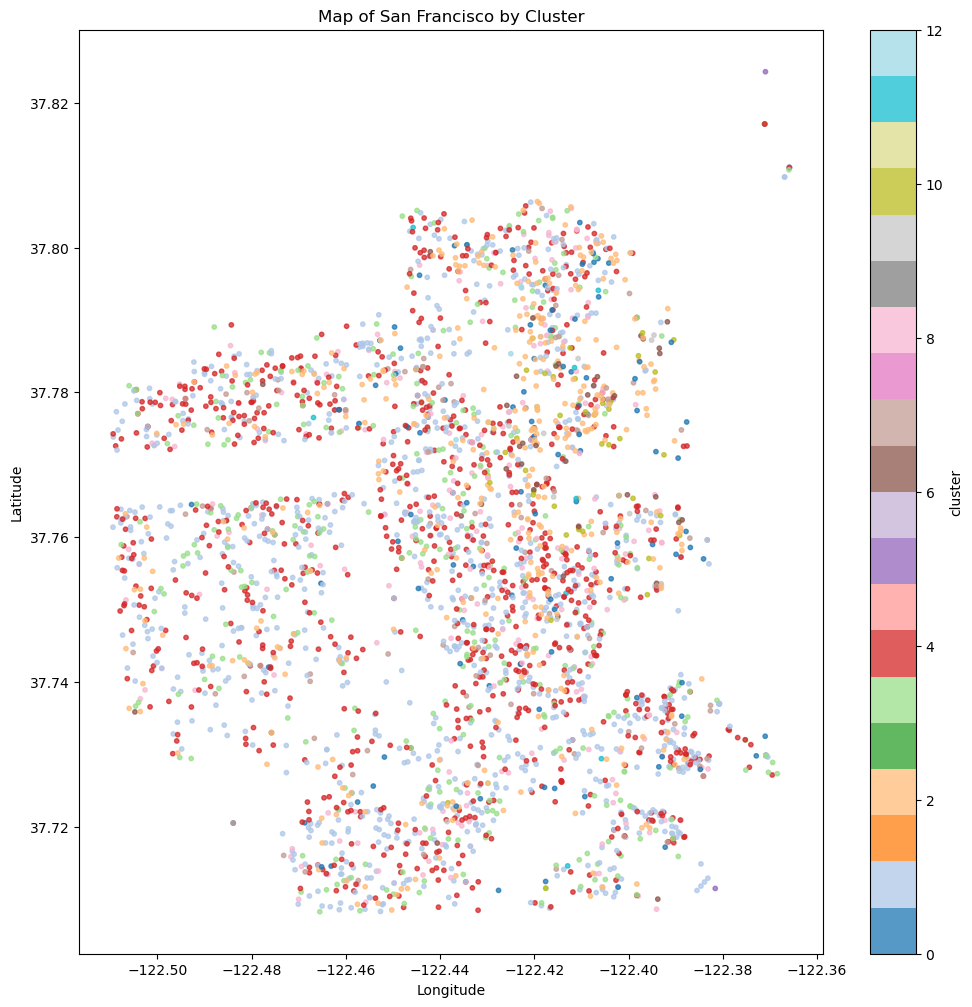

In [124]:
# display where the clusters are
sf_dev_final.plot(kind="scatter", x="longitude", y="latitude", c="cluster",
         cmap="tab20", figsize=(12, 12), s=10, alpha = 0.75)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of San Francisco by Cluster')
plt.savefig('../images/sf_clusters.png');

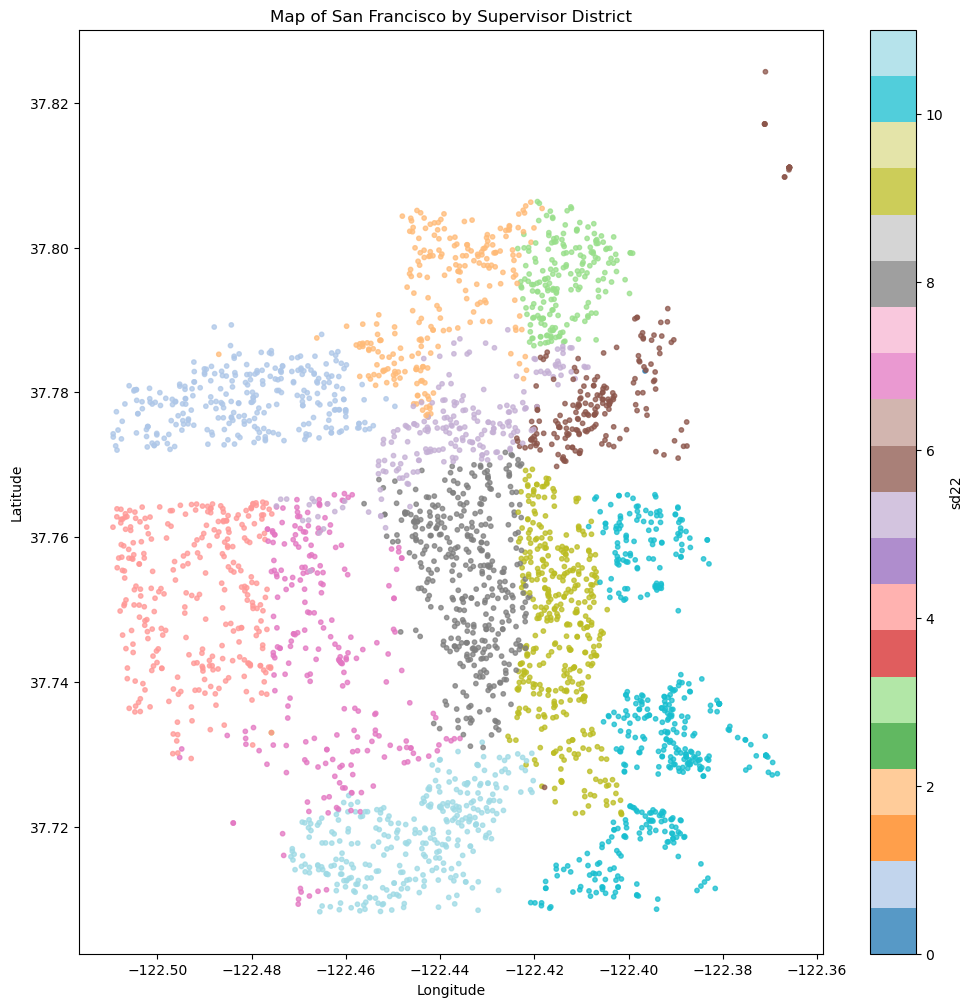

In [119]:
# display where the supervisor districts are
sf_dev_final.plot(kind="scatter", x="longitude", y="latitude", c="sd22",
         cmap="tab20", figsize=(12, 12), s=10, alpha = 0.75)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of San Francisco by Supervisor District');

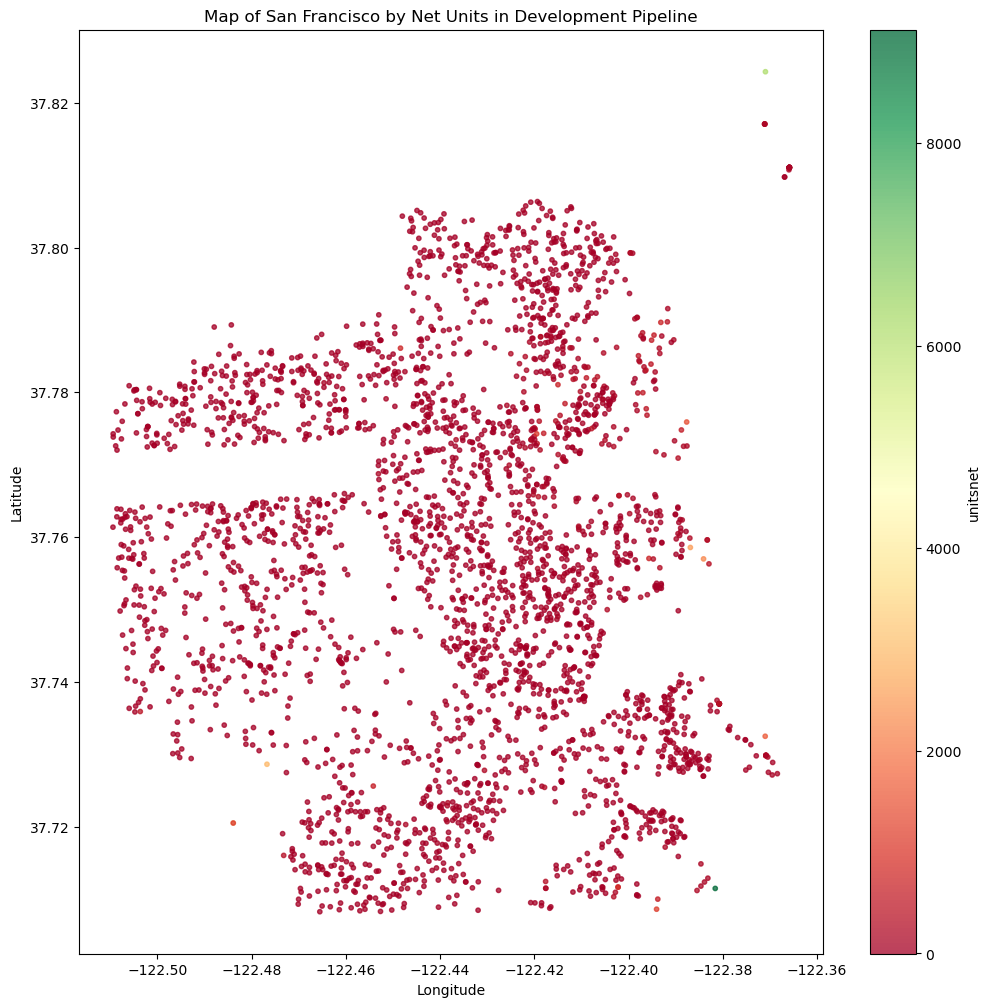

In [120]:
# displays a heatmap of the net units
sf_dev_final.plot(kind="scatter", x="longitude", y="latitude", c="unitsnet", cmap="RdYlGn", 
                  figsize=(12, 12), s=10, alpha = 0.75)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of San Francisco by Net Units in Development Pipeline');

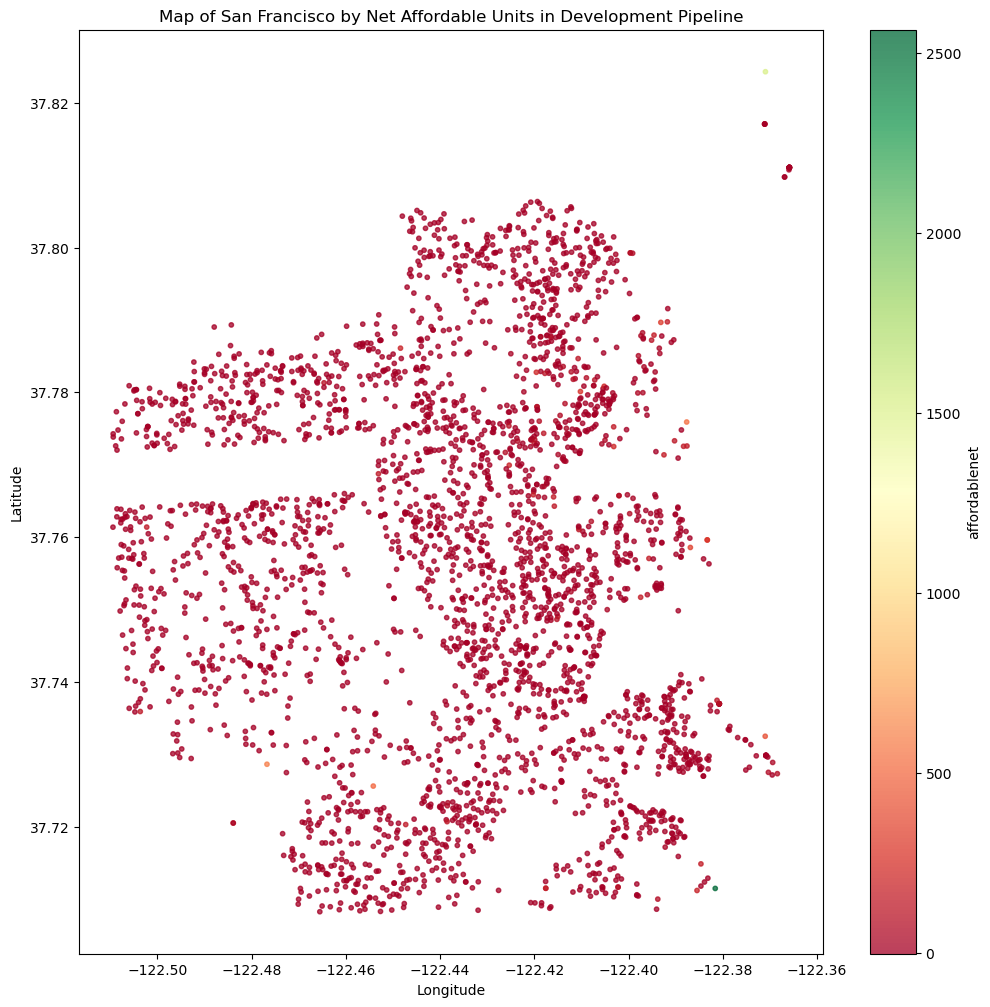

In [125]:
# displays a heat map of net affordable units
sf_dev_final.plot(kind="scatter", x="longitude", y="latitude", c="affordablenet", cmap="RdYlGn", 
                  figsize=(12, 12), s=10, alpha = 0.75)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of San Francisco by Net Affordable Units in Development Pipeline')
plt.savefig('../images/aff_map.png');

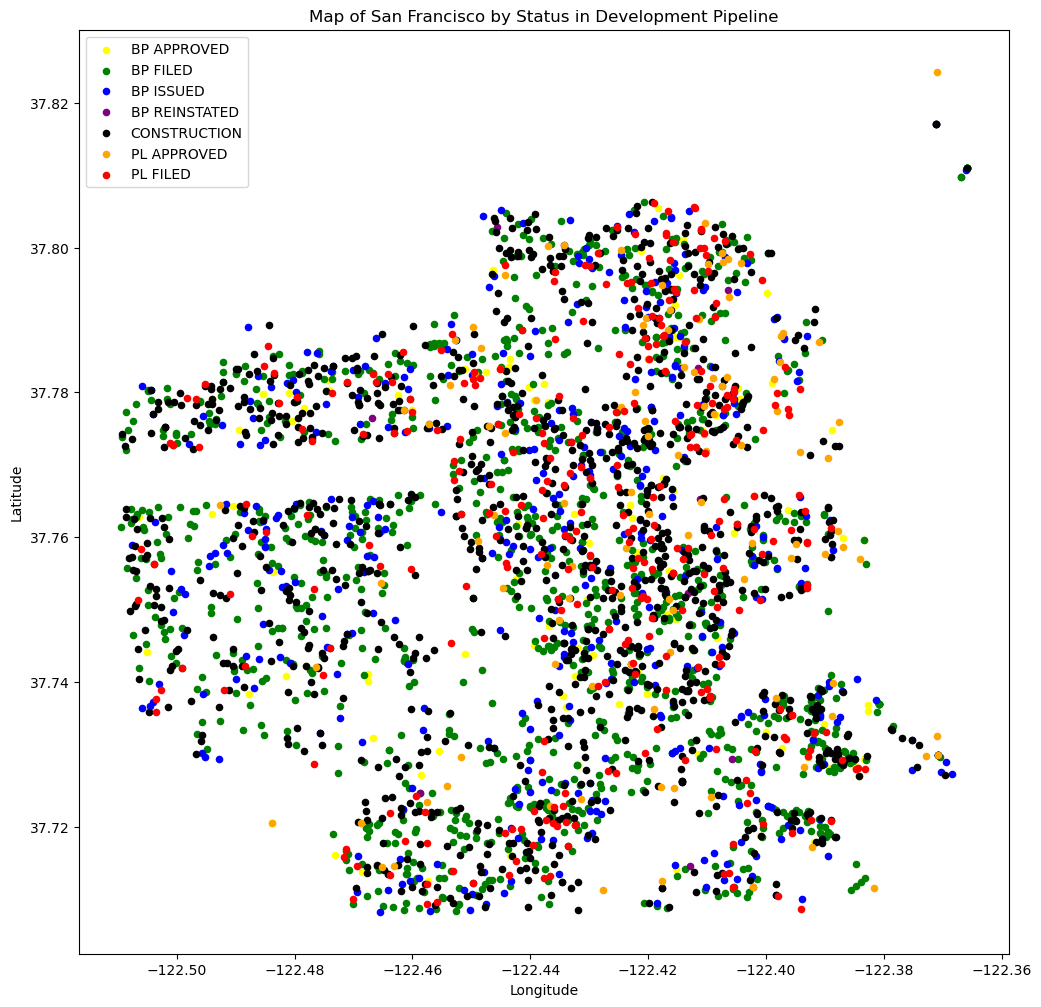

In [122]:
fig, ax = plt.subplots(figsize = (12, 12))

colors = {'PL FILED': 'red',
          'PL APPROVED': 'orange',
          'BP FILED': 'green',
          'BP APPROVED': 'yellow',
          'BP ISSUED': 'blue',
          'BP REINSTATED': 'purple',
          'CONSTRUCTION': 'black'
         }

beststat = sf_dev_final.groupby('beststat')

for key, group in beststat:
    group.plot(ax=ax, kind='scatter', x='longitude', y='latitude', label=key, color=colors[key])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of San Francisco by Status in Development Pipeline')
plt.show();

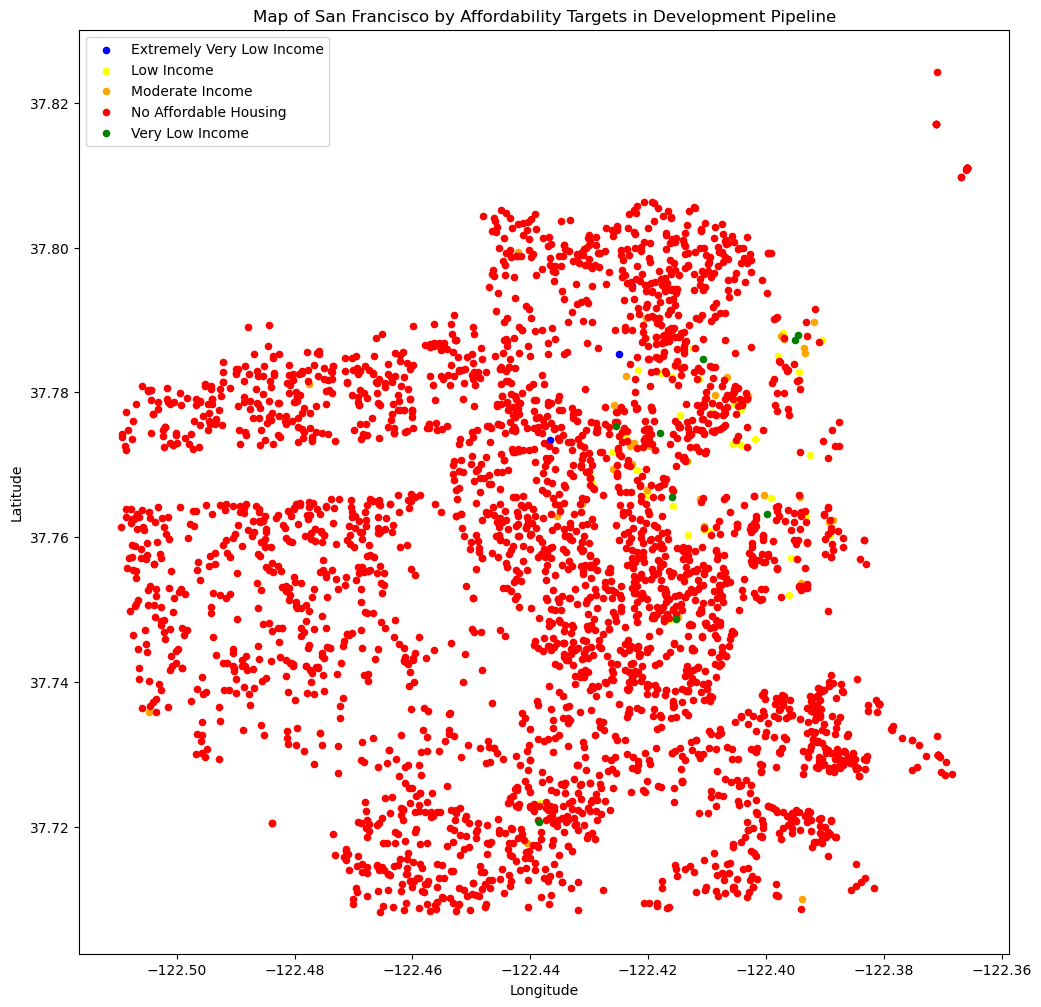

In [126]:
fig, ax = plt.subplots(figsize = (12, 12))

colors = {'No Affordable Housing': 'red',
          'Moderate Income': 'orange',
          'Low Income': 'yellow',
          'Very Low Income': 'green',
          'Extremely Very Low Income': 'blue'
         }

aff_target = sf_dev_final.groupby('afftarget')

for key, group in aff_target:
    group.plot(ax=ax, kind='scatter', x='longitude', y='latitude', label=key, color=colors[key])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of San Francisco by Affordability Targets in Development Pipeline')
plt.savefig('../images/map_aff_targets.png')
plt.show();

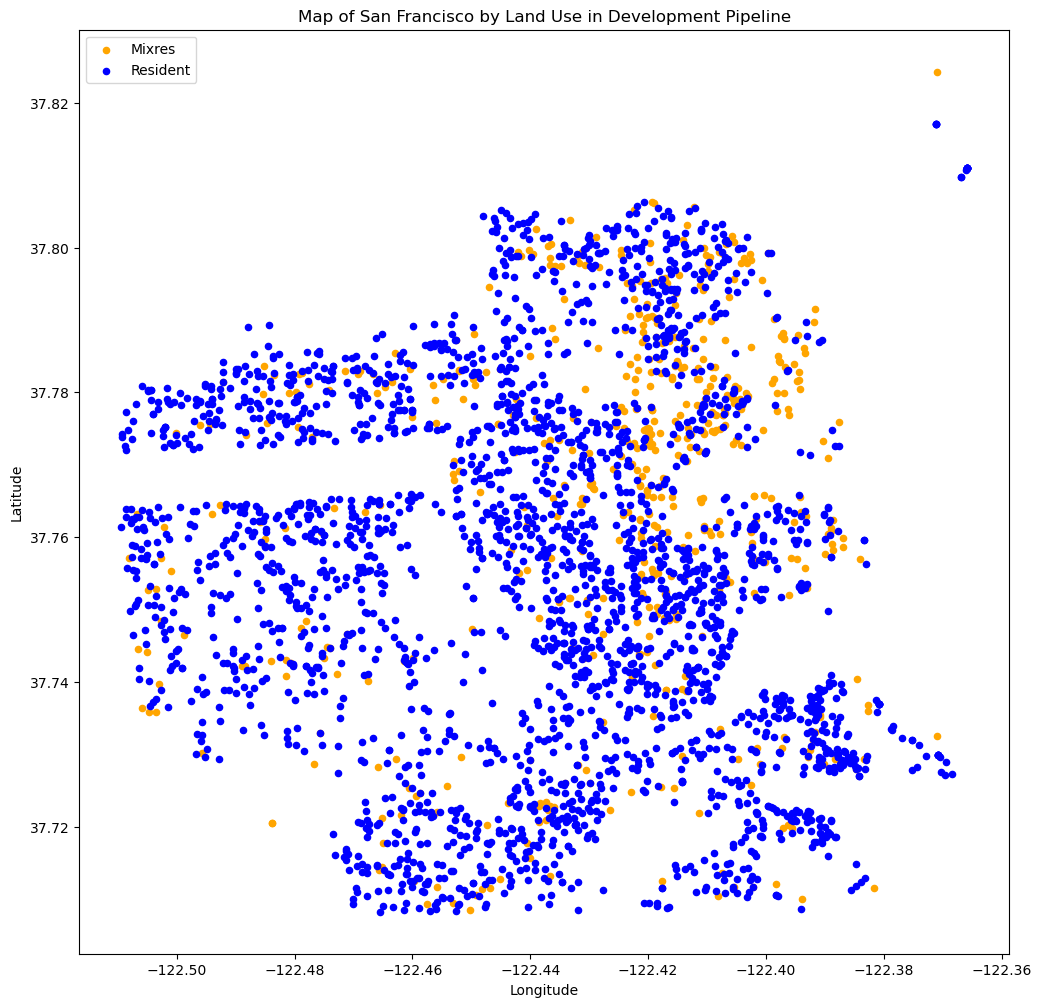

In [127]:
fig, ax = plt.subplots(figsize = (12, 12))

colors = {'Resident': 'blue',
          'Mixres': 'orange'
         }

landuse = sf_dev_final.groupby('landuse')

for key, group in landuse:
    group.plot(ax=ax, kind='scatter', x='longitude', y='latitude', label=key, color=colors[key])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of San Francisco by Land Use in Development Pipeline')
plt.show();

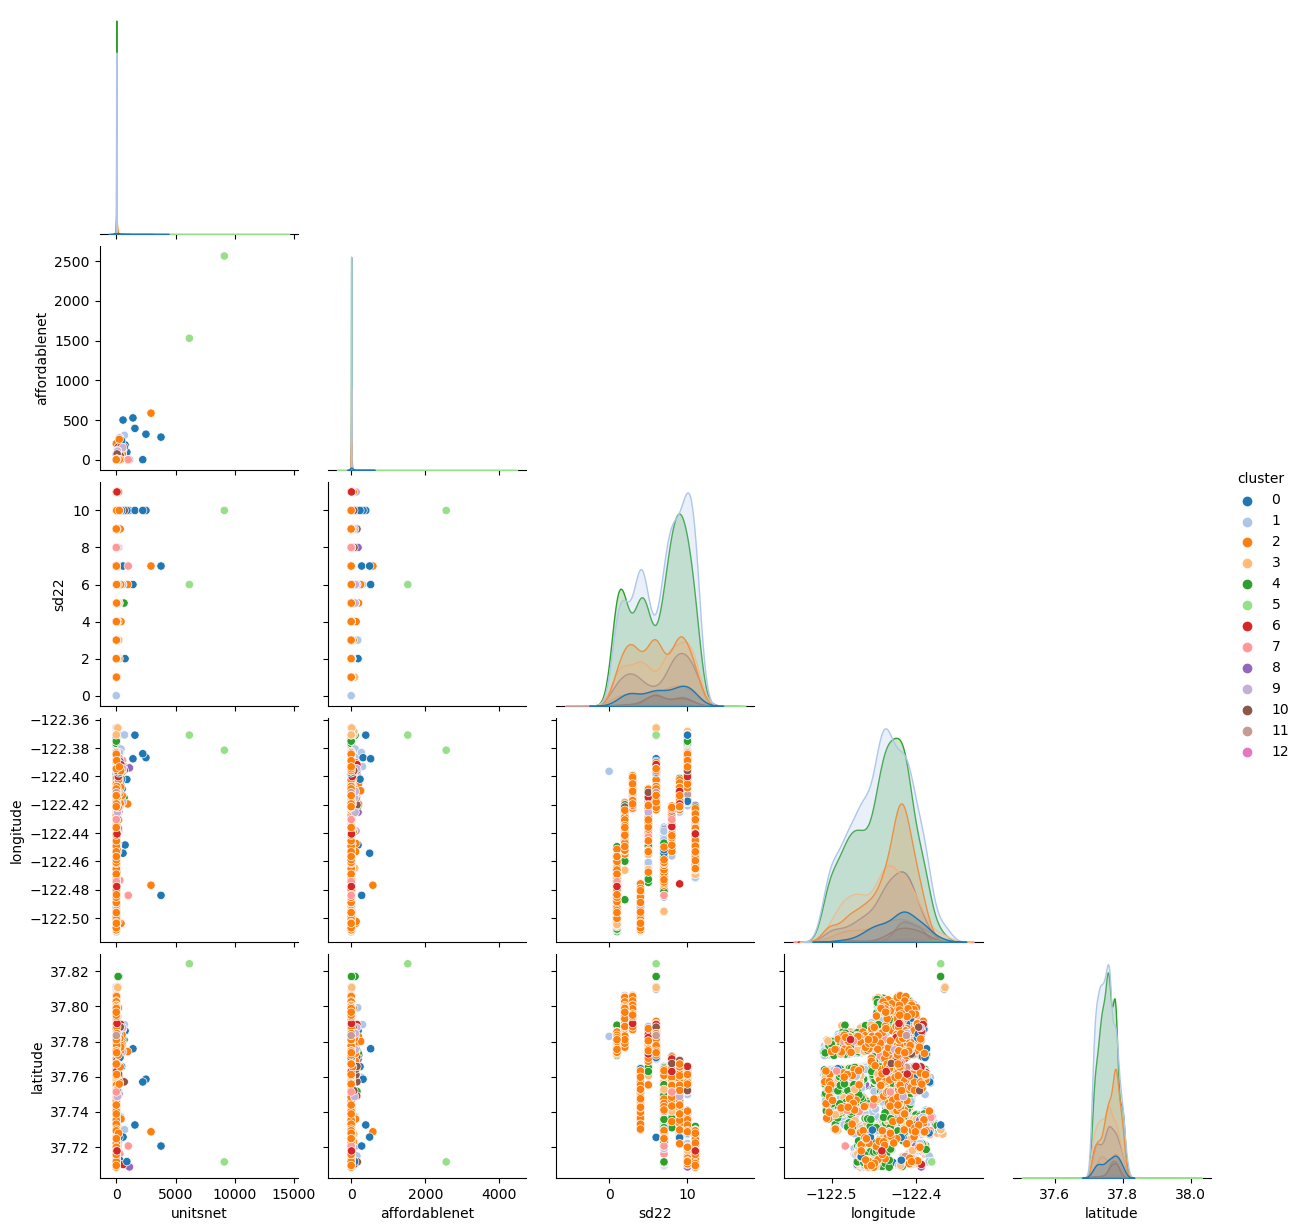

In [128]:
sns.pairplot(sf_dev_final, hue = 'cluster', palette = 'tab20', corner = True);

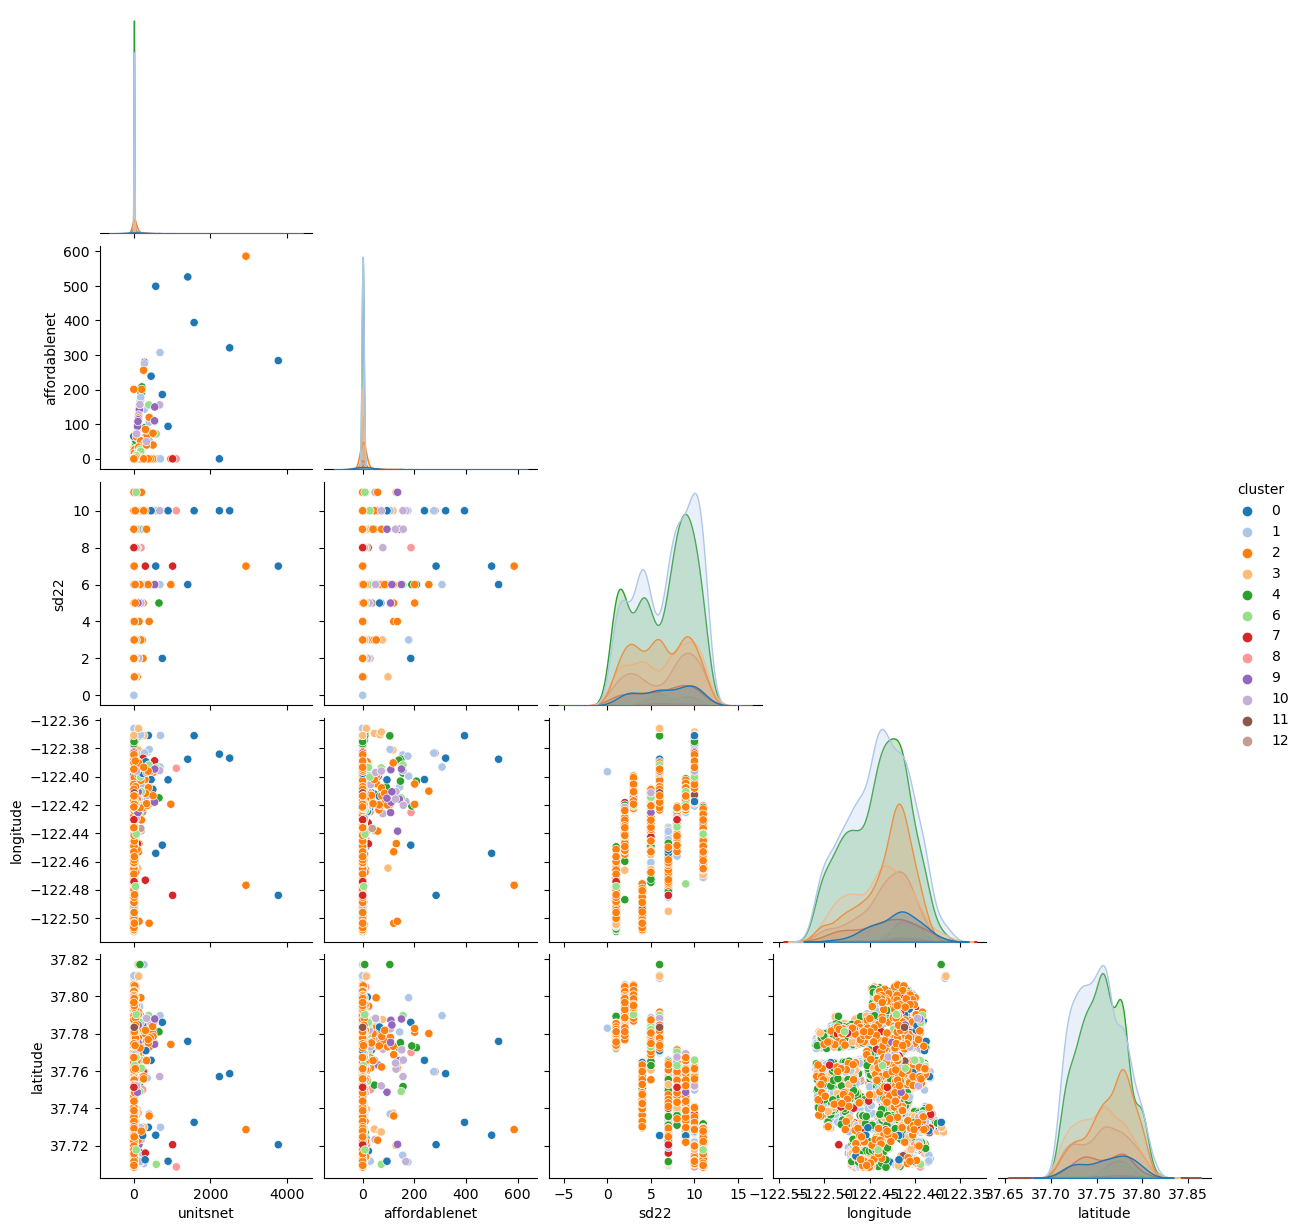

In [129]:
sns.pairplot(sf_dev_final[sf_dev_final['unitsnet'] < 5000], hue = 'cluster', palette = 'tab20', corner = True);

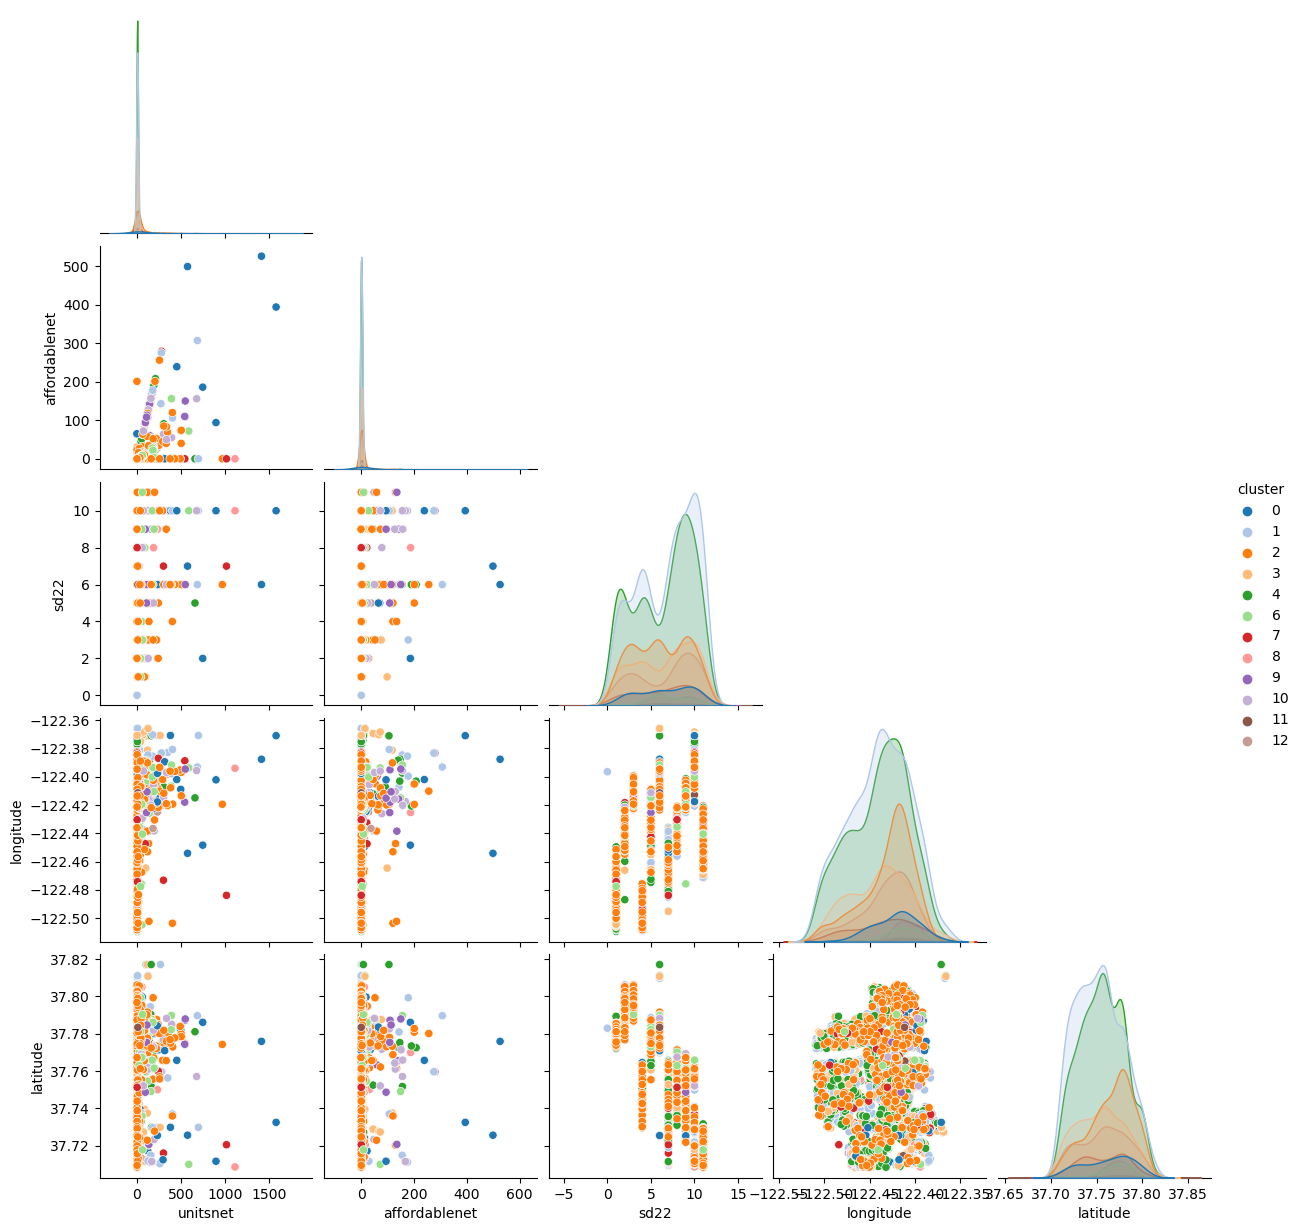

In [130]:
sns.pairplot(sf_dev_final[sf_dev_final['unitsnet'] < 2000], hue = 'cluster', palette = 'tab20', corner = True);

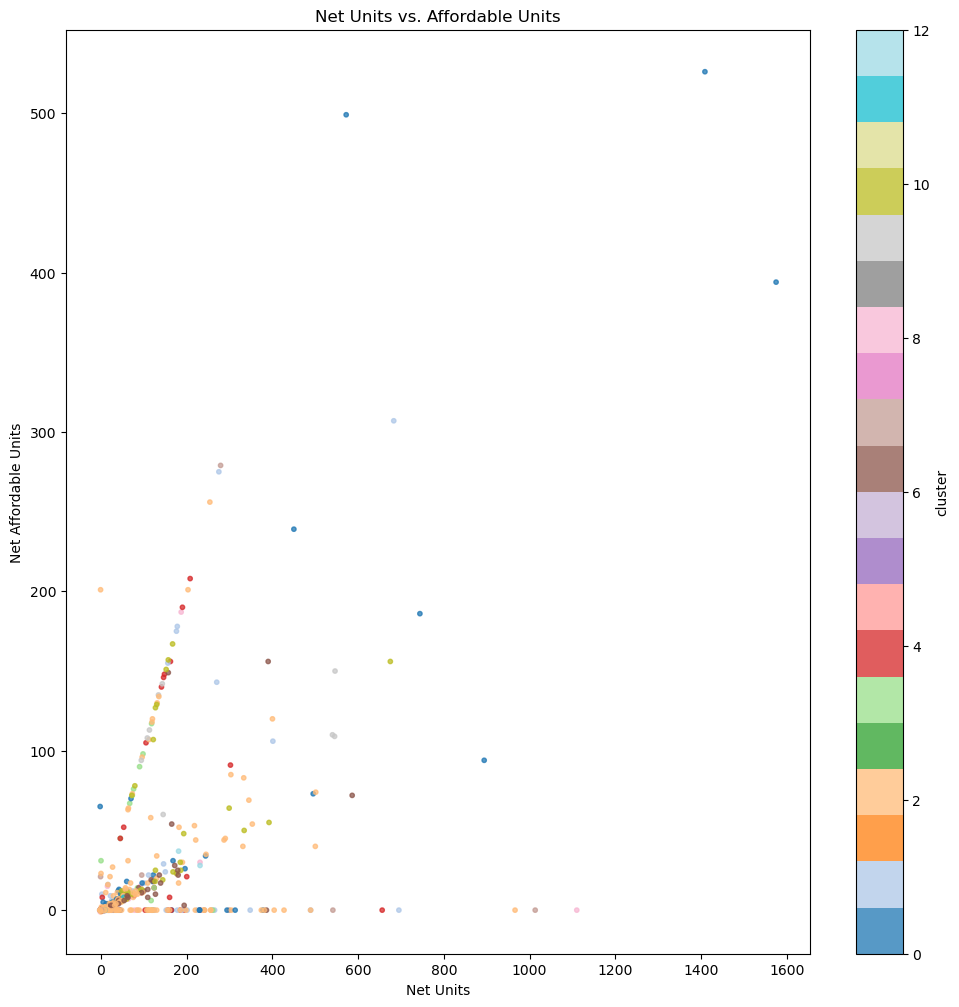

In [131]:
# display scatterplot of net units vs. affordable units
sf_dev_final[sf_dev_final['unitsnet'] < 2000].plot(kind="scatter", x="unitsnet", y="affordablenet", c="cluster",
         cmap="tab20", figsize=(12, 12), s=10, alpha = 0.75)

plt.xlabel('Net Units')
plt.ylabel('Net Affordable Units')
plt.title('Net Units vs. Affordable Units')
plt.savefig('../images/cluster_prop_aff.png');

After multiple peeks into our exploratory data analysis, our clustering model unfortunately does not offer too many insights. Let us look at a few of our data visuals at a time and see what trends we can discern.

First, just looking at the cluster mapped out by latitude and longitude, we see almost no clear pattern in our 13 clusters at least not according to geography. Each of the clusters appear relatively geographically dispersed with concentrations in no particular area. This stands in constrast to the map of the supervisor districts in which there are of course clear boundaries, so the clusters in our final production model cross over potlical boundaries.

Next, looking at the geographic patterns of net units and net affordable units, we can see that the most numerous net units and net affordable units are occurring in projects on the Eastern edge of the city  with the exception of a few projects more central, and a couple in the southwest corner of the city. One very clear pattern though as we saw in our initial EDA is that the high net units coincide with the high net affordable units, so it continues to be a small share of projects which make up the overwhelming majority of the net units and net affordable units. Observing the most recent status of each project though there is no clear pattern or trend. Similar to what we saw in the location of clusters, the status of whether the planning department has approved, the building permit has been approved, or construction has begun seems dispersed across the city.

Where we do see some very clear patterns though are in land use and affordability targets. Both mixed land use projects and affordability targets show a strong pattern of co-occurring in the northeast quadrant of the city and to a lesser extent in the central Mission District neighborhood. These patterns are unsurprising given that these are the densest parts of the city, where most mixed residential projects tend to get proposed for walkable neighborhoods and commerce. These neighborhoods represent areas of socioeconomic diversity.

Lastly, there is little we can glean from our pairplots. Cluster 2 appears numerous and includes a lot of projects with zero net units and zero net affordable units. We zoomed in on our net units and net affordable units by eliminating our extreme outliers. When we zoom in we can see the cluster 6 follows that trend line about 10-15% net affordable units as a proportion of net units and clusters 9 and 10 follow that trend line of 90-100% net affordable units as a proprtion of net units. Perhaps most importantly after zooming in and eliminating the extreme outliers with the highest number of net units and net affordable units, cluster 5 disappears from our analysis entirely.

Perhaps then the most important takeaway is that we pay most attention to patterns in cluster 5, 9, and 10 which tend to follow these trends of a very large number of net affordable units or a high proportion of affordable to total net units.

---

## Notebook Conclusion

In this notebook, we arrived at a clustering production model with 13 clusters. Unfortunately, we did not achieve our goal of a silhouette score of at least 0.75 at the production model only achieved 0.59. Additionally, the clusters themselves do not show clear geographic distinctions or clear distinctions in their housing characteristics. Therefore, we are not able to answer our problem statement in our clustering production model. We shall investigate the second part of our problem statement regarding housing projections in Part 5.